## Instalowanie oraz wstępny import ważnych bibliotek

In [1]:
!pip install SALib pypesto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.4/414.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.8 MB/s eta 0:00:00


In [2]:
from SALib.sample import saltelli, sobol,  morris as morris_sample
from SALib.sample import sobol as sobol_sampler
from SALib.analyze import sobol, morris as morris_analyze
from SALib.test_functions import Ishigami
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pypesto
import pypesto.optimize as optimize
from pypesto.objective import Objective
from tqdm import tqdm_notebook
from matplotlib.pyplot import cm

## Model Bazowy (Zadanie 1 / Dodatkowe )

Model bazowy stworzony z połączenia dwóch początkowych modeli zaproponowanych w pracy naukowej na której opiera się ten projekt (dokument w Teams). Mały model zaproponowany w papierze miał zbyt mało parametrów i był bardzo prosty. Duży model natomiast był zbytnio skomplikowany z ogromną ilością parametrów. Po wielu próbach oraz błędach, został stworzony model pośredni, który do najmniejszego modelu wprowadził regenerację komórek oraz reakcję odpornościową.

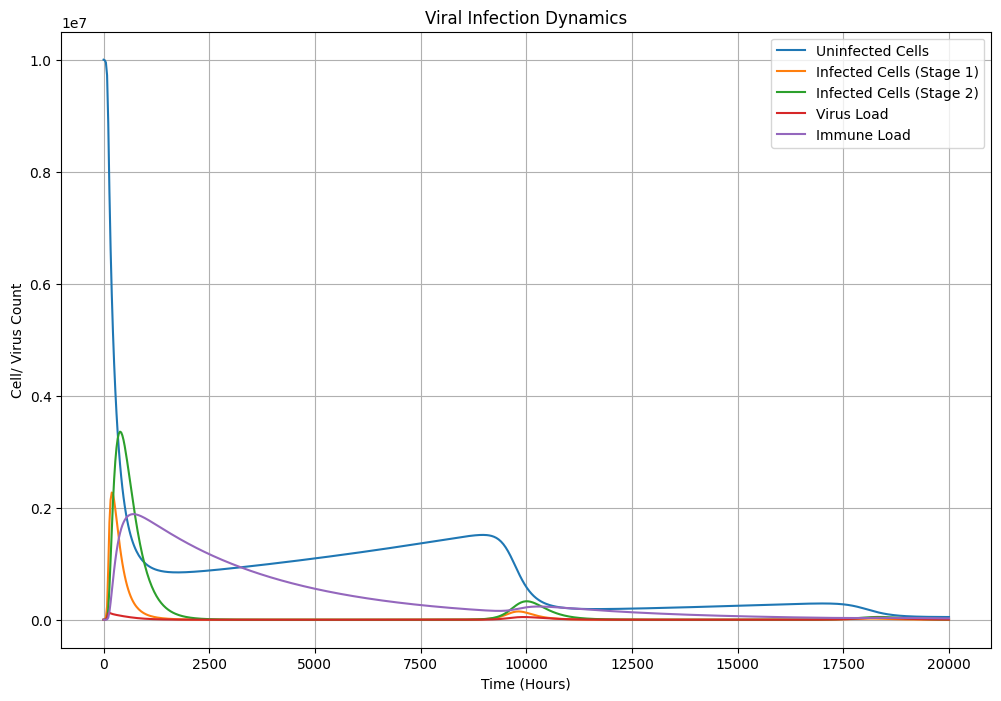

In [3]:
import numpy as np

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
beta = 7.18*600*1e-11  # infection rate
k = 1.85*600*1e-5      # infected_to_transitioning_conv_rate
d = 2.78*600*1e-6 * 2.5     # death rate
p = 3.79*600*1e-4 * .6   # virus production rate
c = 1.09*600*1e-4     # virus decay rate
cp = 1e-5 * 4
cd = 1e-4 * 3
ck = 1e-6 * 4
r = 1e-4

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1000 # initial virus load
C0 = 0

# Time points (days)
t = np.linspace(0, 20000, 720)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, V0, C0]

# Solve ODE
solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))

# Plot results
U, I1, I2, V, C = solution.T
plt.figure(figsize=(12, 8))
plt.plot(t, U, label='Uninfected Cells')
plt.plot(t, I1, label='Infected Cells (Stage 1)')
plt.plot(t, I2, label='Infected Cells (Stage 2)')
plt.plot(t, V, label='Virus Load')
plt.plot(t, C, label='Immune Load')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell/ Virus Count')
plt.legend()
plt.title('Viral Infection Dynamics')
plt.grid()
plt.show()


Jak na wykresie można zobaczyć, po pierwszej dużej infekcji nasepują również pomniejsze kolejne infekcje. Dzieje się tak, aż organizm całkowicie umrze.

## Metoda Sobola (Zadanie 2)

Poniżej przeprowadzone zostanie badanie wpływu współczynników modelu na wynik przy użyciu metody Sobola. Weźmiemy pod uwagę indeks pierwszego oraz totalnego rzędu. Pierwszy rząd bada wpływ zmiany  pojedyńczego parametru na wynik modelu, gdzie totalny rząd bada zmianę uwzględniając interakcję z innymi parametrami. Maksymalny oraz minimalnt zakres parametrów stanowić będą bazowy parametr modelu *2 lub /2.

In [ ]:
t = np.linspace(0, 20000, 720)

In [ ]:
problem = {
    'num_vars': 14,
    'names': ['U0','I1_0','I2_0', 'V0','C0', 'beta', 'k', 'd', 'p', 'c', 'cp', 'cd','ck','r'],
    'bounds': [
        [U0/2,U0*2],
        [0,1000],
        [0,1000],
        [V0/2,V0*2],
        [0,1000],
        [beta/2,beta*2],
        [k/2,k*2],
        [d/2,d*2],
        [p/2,p*2],
        [c/2,c*2],
        [cp/2,cp*2],
        [cd/2,cd*2],
        [ck/2,ck*2],
        [r/2,r*2]
    ]
}

W badaniu wyłączony zostanie drugi rząd, który bada również interackję pomiędzy parami parametrów.

In [ ]:
param_values_sobol = sobol.sample(problem, 1024, calc_second_order=False)

In [27]:
def evaluate_model(params):
    U0,I1_0,I2_0, V0, C0, beta, k, d, p, c, cp, cd, ck, r = params
    y0 = [U0, I1_0, I2_0, V0, C0]
    solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))
    U, I1, I2, V, C = solution.T
    return U, I1, I2, V, C

In [ ]:
Us, I1s, I2s, Vs, Cs = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol):
  U, I1, I2, V, C = evaluate_model(params)
  Us.append(U)
  I1s.append(I1)
  I2s.append(I2)
  Vs.append(V)
  Cs.append(C)

<ipython-input-10-48da4d15fb7b>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol):


  0%|          | 0/16384 [00:00<?, ?it/s]

<ipython-input-3-6712a5f39243>:13: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I1**1.3 - cd * C
<ipython-input-9-5c34099945a0>:4: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))
<ipython-input-9-5c34099945a0>:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))


In [ ]:
Us = np.array(Us)
I1s = np.array(I1s)
I2s = np.array(I2s)
Cs = np.array(Cs)
Vs = np.array(Vs)

Analizuje każdy krok czasowy pojedyńczo, aby odkryć jaki wpływ współczynników jest w czasie.

In [ ]:
resultsU = []
resultsI1 = []
resultsI2 = []
resultsV = []
resultsC = []
for time_ in tqdm_notebook(range(1,720)):
  resultsU.append(sobol.analyze(problem, Us[:,time_], calc_second_order=False))
  resultsI1.append(sobol.analyze(problem, I1s[:,time_], calc_second_order=False))
  resultsI2.append(sobol.analyze(problem, I2s[:,time_], calc_second_order=False))
  resultsV.append(sobol.analyze(problem, Vs[:,time_], calc_second_order=False))
  resultsC.append(sobol.analyze(problem, Cs[:,time_], calc_second_order=False))

<ipython-input-12-f4b7e595e975>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,720)):


  0%|          | 0/719 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
S1MatrixU = np.array([result['S1'] for result in resultsU])
STMatrixU = np.array([result['ST'] for result in resultsU])
S1MatrixI1 = np.array([result['S1'] for result in resultsI1])
STMatrixI1 = np.array([result['ST'] for result in resultsI1])
S1MatrixI2 = np.array([result['S1'] for result in resultsI2])
STMatrixI2 = np.array([result['ST'] for result in resultsI2])
S1MatrixV = np.array([result['S1'] for result in resultsV])
STMatrixV = np.array([result['ST'] for result in resultsV])
S1MatrixC = np.array([result['S1'] for result in resultsC])
STMatrixC = np.array([result['ST'] for result in resultsC])

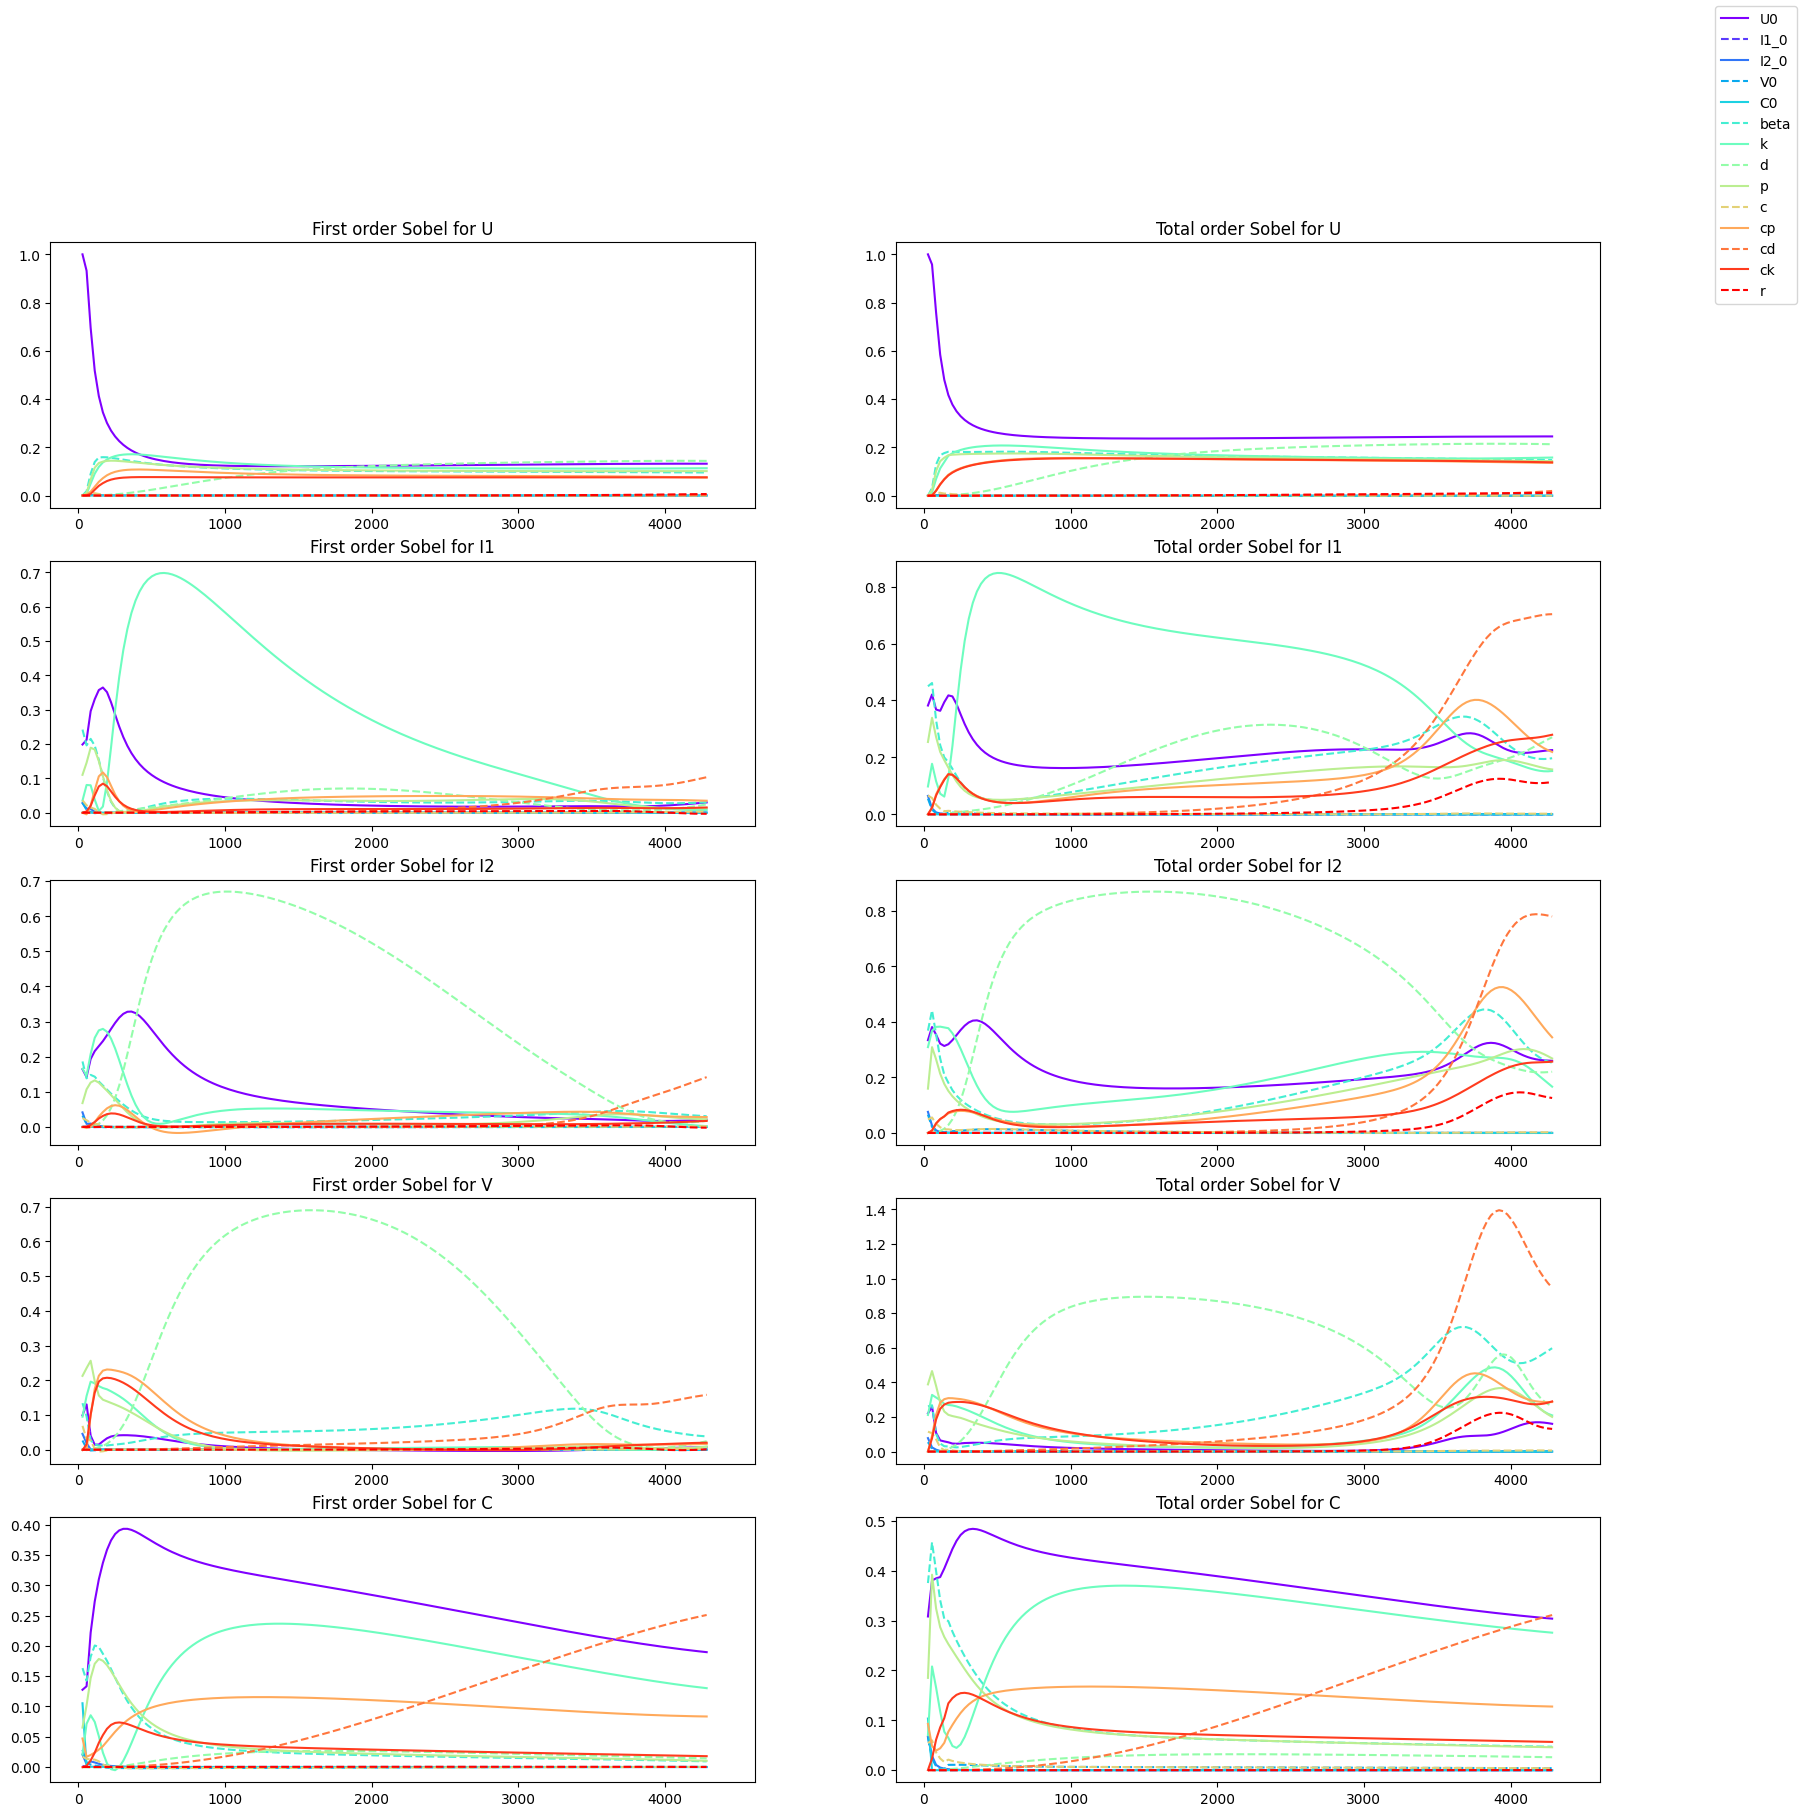

In [ ]:
color = cm.rainbow(np.linspace(0, 1, problem['num_vars']))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixU,STMatrixU],
            [S1MatrixI1,STMatrixI1],
            [S1MatrixI2,STMatrixI2],
            [S1MatrixV,STMatrixV],
            [S1MatrixC,STMatrixC]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','V','C']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(problem['num_vars']),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

Mamy wykresu, jendkaże dla szerszego obrazu zrobimy wynik średni

In [ ]:
all_scores = np.concatenate([el for arr in matrices for el in arr])
mask = np.isnan(all_scores.mean(axis=1))
all_scores_clean = all_scores[~mask]
means = all_scores_clean.mean(axis=0)
for label, mean in zip(problem['names'],means):
  print(f"{label}: {mean}")

U0: 0.1704665704990507
I1_0: 1.7427658655274037e-05
I2_0: 0.0005409504775106586
V0: 0.0011903308984518293
C0: 0.00013720238190663265
beta: 0.11340852234993333
k: 0.19704307683899724
d: 0.24485169173356847
p: 0.08296482001047499
c: 0.0023160000590082344
cp: 0.10139324917346326
cd: 0.08735528427753866
ck: 0.06953452416848786
r: 0.009208504856990029


Jak można dostrzec najbardziej poważnymi czynnikami są **k**, czyli szybkość zakażenia komórki przez wirusa, początkowa ilość zdrowych komórek oraz szybkość umierania komórek zakażonych. Innymi słowy bardzo istotne w tym modelu są komórki wytwarzające wirusa. Wpływ odpornościowy nie jest na tyle ważny, gdyż parametry za nie odpowiedzialne są dość małe. Najmniej ważnymi są wartości początkowe oraz wartości r oraz c. Jeden odpowiada za samoistną śmierć wirusa (c), a drugi za tempo regeneracji organizmu.

Zbadamy jeszcze jak działa czułość po wyrzuceniu najmniej czułych parametrów i niektórych wartości początkowych.

In [ ]:
t = np.linspace(0, 20000, 360)  # simulate for 50 days

In [ ]:
problem = {
    'num_vars': 9,
    'names': ['U0','I1_0', 'beta', 'k', 'd', 'p', 'cp', 'cd','ck'],
    'bounds': [
        [U0/1.5,U0*1.5],
        [0,200],
        [beta/1.5,beta*1.5],
        [k/1.5,k*1.5],
        [d/1.5,d*1.5],
        [p/1.5,p*1.5],
        [cp/1.5,cp*1.5],
        [cd/1.5,cd*1.5],
        [ck/1.5,ck*1.5]
    ]
}

In [ ]:
def evaluate_model2(params):
    U0,I1_0, beta, k, d, p, cp, cd, ck = params
    y0 = [U0, I1_0, 0,1000, 0]
    solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, 1.09*600*1e-4, 1e-4, cp, cd, ck, U0+I1_0))
    U, I1, I2, V, C = solution.T
    return U, I1, I2, V, C

In [ ]:
param_values_sobol2 = sobol_sampler.sample(problem, 1024, calc_second_order=False)

In [ ]:
Uss, I1ss, I2ss, Vss, Css = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol2):
  U, I1, I2, V, C = evaluate_model2(params)
  Uss.append(U)
  I1ss.append(I1)
  I2ss.append(I2)
  Css.append(C)
  Vss.append(V)

<ipython-input-153-49a883272dd7>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol2):


  0%|          | 0/11264 [00:00<?, ?it/s]

<ipython-input-93-0563ec450df6>:13: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I1**1.3 - cd * C
<ipython-input-151-26168b8152e4>:4: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, 1.09*600*1e-4, 1e-4, cp, cd, ck, U0+I1_0))


In [ ]:
Uss = np.array(Uss)
I1ss = np.array(I1ss)
I2ss = np.array(I2ss)
Css = np.array(Css)
Vss = np.array(Vss)

In [ ]:
resultsUs = []
resultsI1s = []
resultsI2s = []
resultsCs = []
resultsVs = []
for time_ in tqdm_notebook(range(1,720)):
  resultsUs.append(sobol.analyze(problem, Uss[:,time_], calc_second_order=False))
  resultsI1s.append(sobol.analyze(problem, I1ss[:,time_], calc_second_order=False))
  resultsI2s.append(sobol.analyze(problem, I2ss[:,time_], calc_second_order=False))
  resultsCs.append(sobol.analyze(problem, Css[:,time_], calc_second_order=False))
  resultsVs.append(sobol.analyze(problem, Vss[:,time_], calc_second_order=False))

<ipython-input-155-42977c3f5976>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,720)):


  0%|          | 0/719 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/sobol.py:216: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/sobol.py:229: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdi

In [ ]:
S1MatrixUs = np.array([result['S1'] for result in resultsUs])
STMatrixUs = np.array([result['ST'] for result in resultsUs])
S1MatrixI1s = np.array([result['S1'] for result in resultsI1s])
STMatrixI1s = np.array([result['ST'] for result in resultsI1s])
S1MatrixI2s = np.array([result['S1'] for result in resultsI2s])
STMatrixI2s = np.array([result['ST'] for result in resultsI2s])
S1MatrixCs = np.array([result['S1'] for result in resultsCs])
STMatrixCs = np.array([result['ST'] for result in resultsCs])
S1MatrixVs = np.array([result['S1'] for result in resultsVs])
STMatrixVs = np.array([result['ST'] for result in resultsVs])

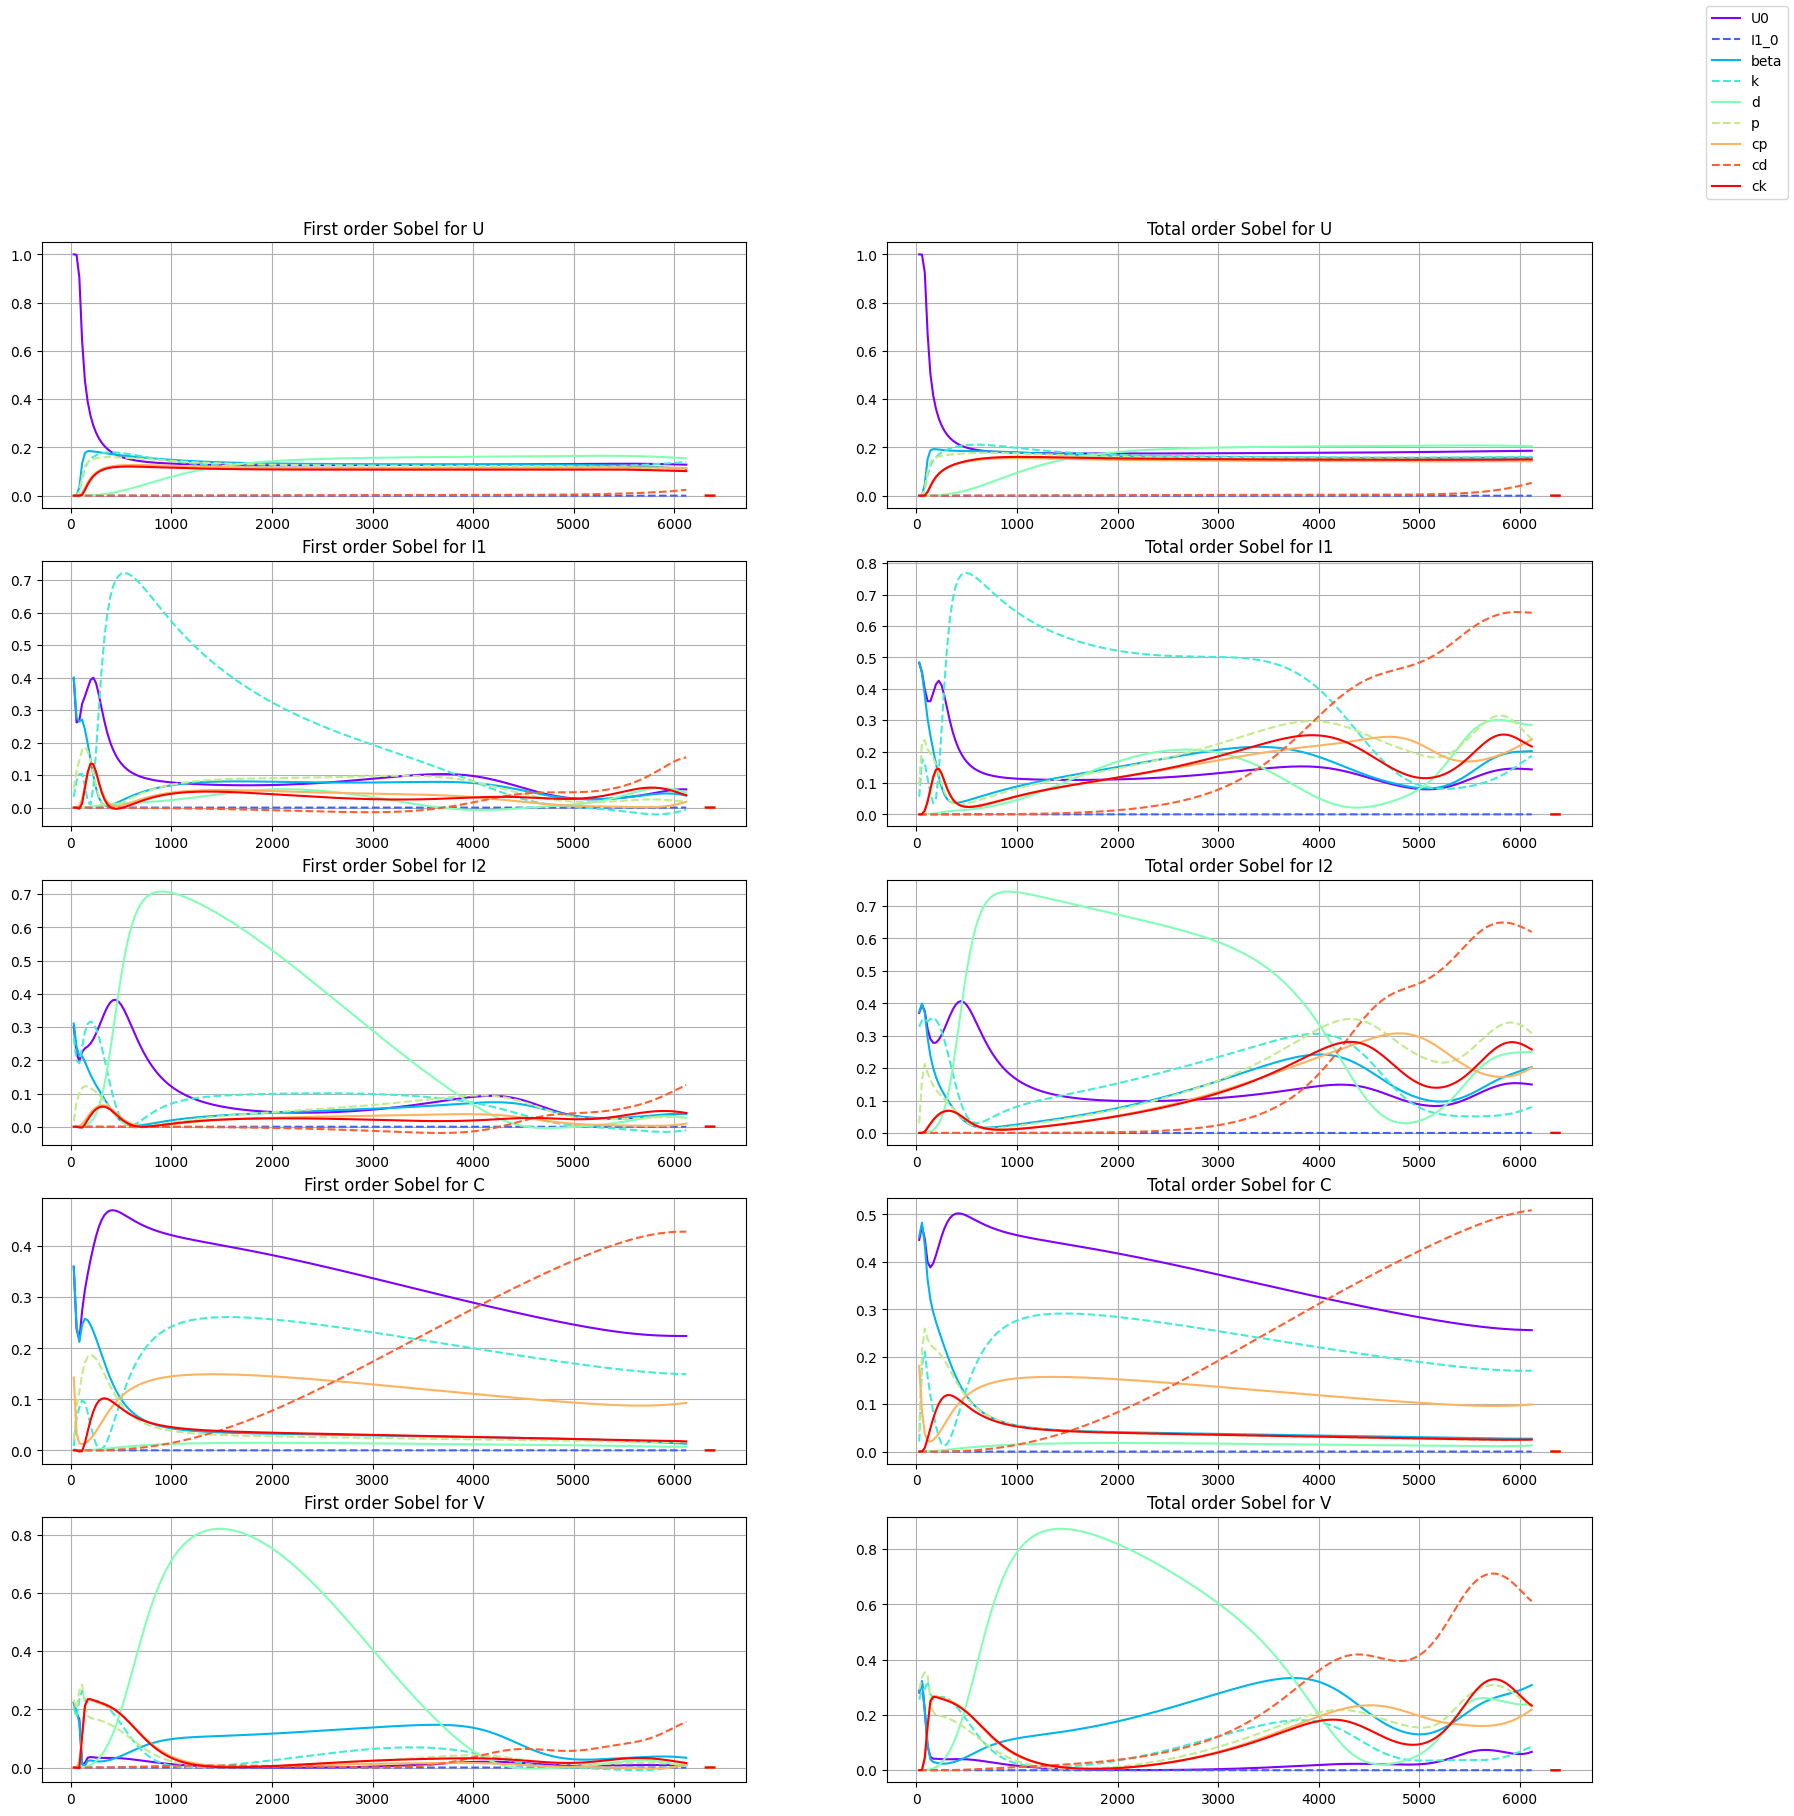

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 9))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixUs,STMatrixUs],
            [S1MatrixI1s,STMatrixI1s],
            [S1MatrixI2s,STMatrixI2s],
            [S1MatrixCs,STMatrixCs],
            [S1MatrixVs,STMatrixVs]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','C','V']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(9),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [ ]:
all_scores = np.concatenate([el for arr in matrices for el in arr])
mask = np.isnan(all_scores.mean(axis=1))
all_scores_clean = all_scores[~mask]
means = all_scores_clean.mean(axis=0)
for label, mean in zip(problem['names'],means):
  print(f"{label}: {mean}")

U0: 0.1520400457406601
I1_0: 9.772534058232996e-06
beta: 0.1065813706136371
k: 0.16653819060360522
d: 0.18572894296010983
p: 0.10006231401283051
cp: 0.09733035838186803
cd: 0.10867426463276014
ck: 0.08110418452813331


Ostatecznie dużo się nie zmieniło, zmienne trzymają się mniej więcej tych samych wyników, lecz może trochę nizszych (patrząc na zmienne). Mówi nam to, że mało znaczące zmienne, nadal odgrywały pewną rolę.

## Meroda Morrisa (Zadanie 2)

Poniżej zostanie użyta metoda Morrisa, dokładnie w tym samym celu co Sobola. Będziemy używać metryki u* (wartość oczekiwana dla wartości elementarnych absolutnych), która oznacza siłę wpływu danego parametru (bez interakcji) na wynik modelu.

In [24]:
problem = {
    'num_vars': 14,
    'names': ['U0','I1_0','I2_0', 'V0','C0', 'beta', 'k', 'd', 'p', 'c', 'cp', 'cd','ck','r'],
    'bounds': [
        [U0/2,U0*2],
        [0,1000],
        [0,1000],
        [V0/2,V0*2],
        [0,1000],
        [beta/2,beta*2],
        [k/2,k*2],
        [d/2,d*2],
        [p/2,p*2],
        [c/2,c*2],
        [cp/2,cp*2],
        [cd/2,cd*2],
        [ck/2,ck*2],
        [r/2,r*2]
    ]
}
param_values = morris_sample.sample(problem, 1024)

In [28]:
Uss, I1ss, I2ss, Vss, Css = [], [], [], [], []
for params in tqdm_notebook(param_values):
  U, I1, I2, V, C = evaluate_model(params)
  Uss.append(U)
  I1ss.append(I1)
  I2ss.append(I2)
  Css.append(C)
  Vss.append(V)

<ipython-input-28-ab504066ccb4>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values):


  0%|          | 0/15360 [00:00<?, ?it/s]

<ipython-input-3-443cc503c37e>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I1**1.3 - cd * C
<ipython-input-27-5c34099945a0>:4: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))
<ipython-input-27-5c34099945a0>:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))


In [29]:
Uss = np.array(Uss)
I1ss = np.array(I1ss)
I2ss = np.array(I2ss)
Css = np.array(Css)
Vss = np.array(Vss)

In [30]:
resultsUs = []
resultsI1s = []
resultsI2s = []
resultsCs = []
resultsVs = []
for time_ in range(1,720):
  resultsUs.append(morris_analyze.analyze(problem, param_values, Uss[:,time_] ))
  resultsI1s.append(morris_analyze.analyze(problem,  param_values,I1ss[:,time_]))
  resultsI2s.append(morris_analyze.analyze(problem,  param_values,I2ss[:,time_] ))
  resultsCs.append(morris_analyze.analyze(problem,  param_values,Css[:,time_] ))
  resultsVs.append(morris_analyze.analyze(problem,  param_values,Vss[:,time_]))

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/SALib/analyze/morris.py:412: RuntimeWarning: overflow encountered in divide
  elementary_effects = difference / delta


In [36]:
S1MatrixUs = np.array([result['mu_star'] for result in resultsUs])
S1MatrixI1s = np.array([result['mu_star'] for result in resultsI1s])
S1MatrixI2s = np.array([result['mu_star'] for result in resultsI2s])
S1MatrixCs = np.array([result['mu_star'] for result in resultsCs])
S1MatrixVs = np.array([result['mu_star'] for result in resultsVs])

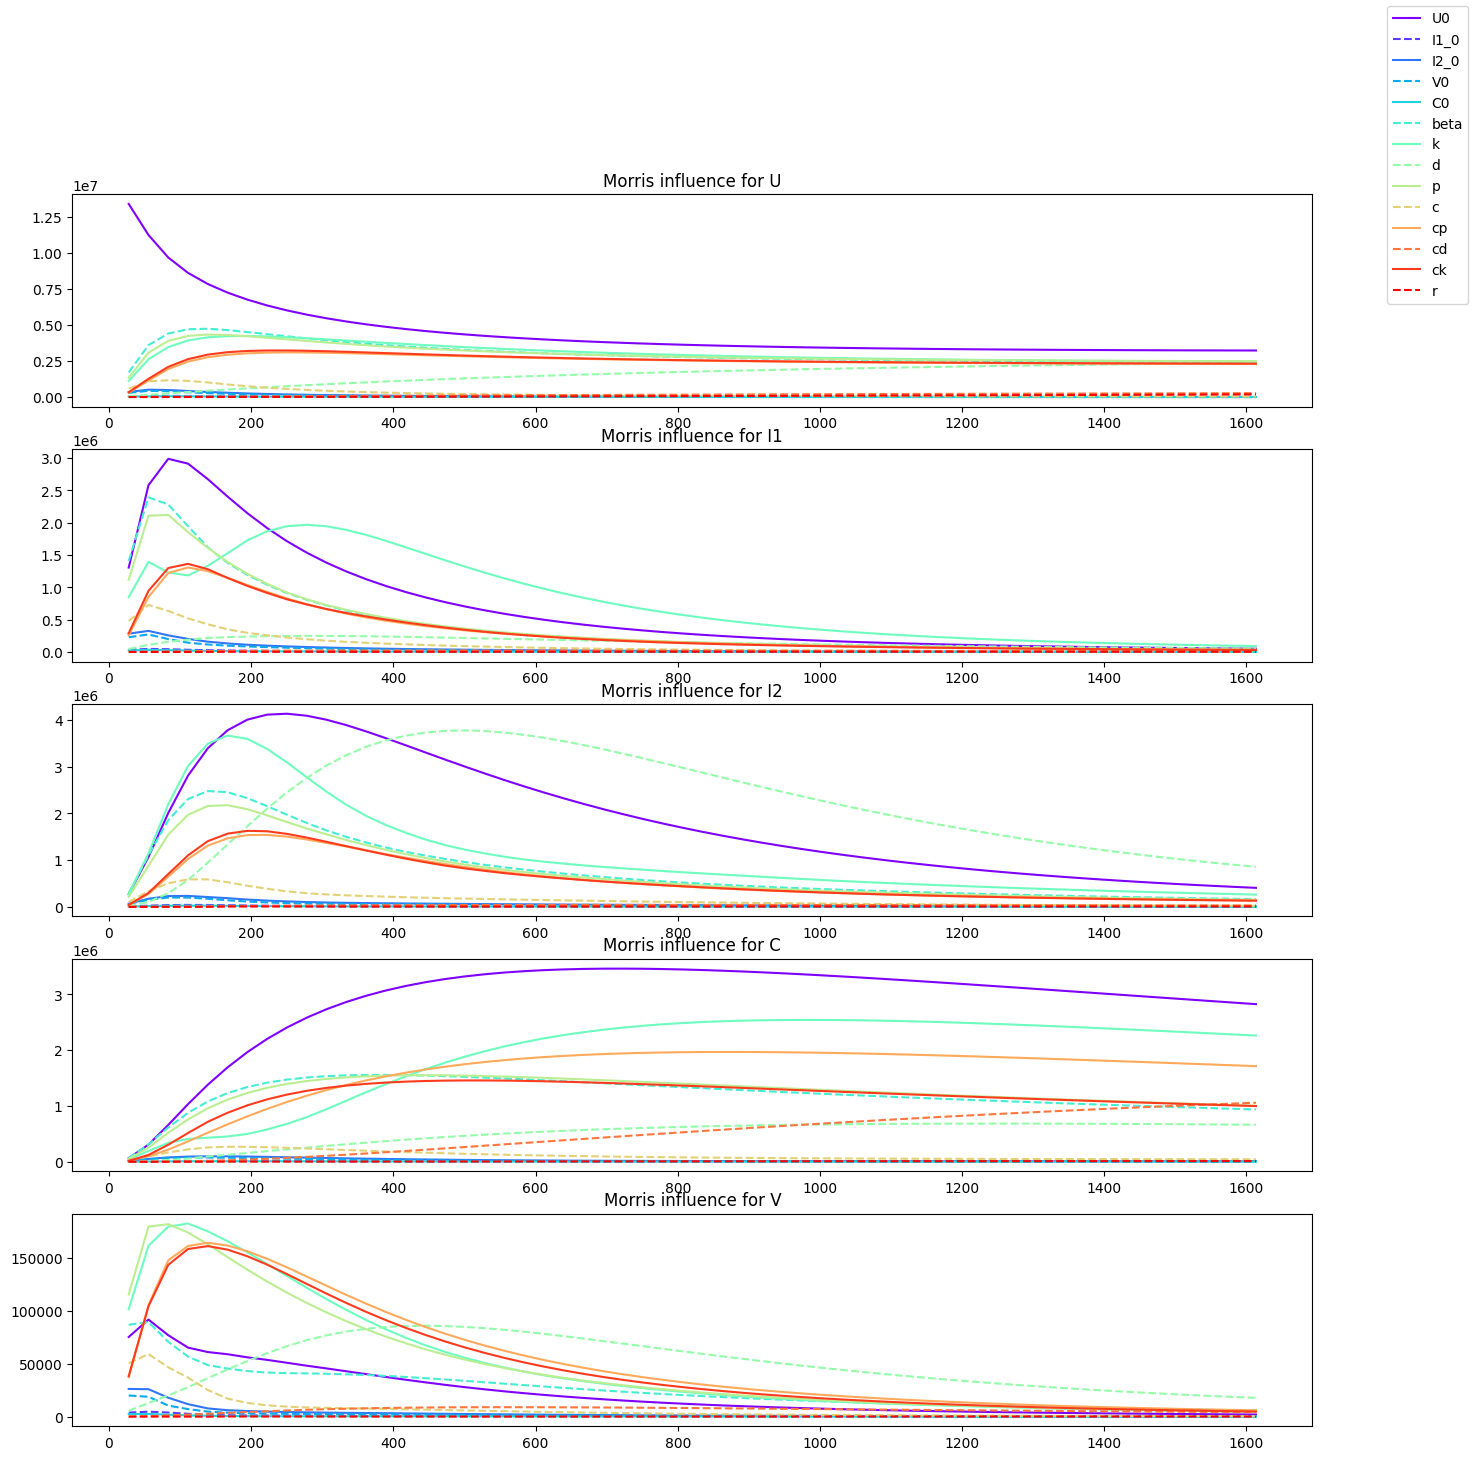

In [53]:
color = cm.rainbow(np.linspace(0, 1, problem['num_vars']))
fig, axes = plt.subplots(5,1)
matrices = [S1MatrixUs,
            S1MatrixI1s,
            S1MatrixI2s,
            S1MatrixCs,
            S1MatrixVs]

variables = ['U','I1','I2','C','V']
fig.set_size_inches(16,16)

for row in range(5):
  for name, col_, color_ in zip(problem['names'],range(problem['num_vars']),color):
    axes[row].plot(t[1:60], matrices[row][1:60,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
    axes[row].grid()
    axes[row].set_title('Morris influence for ' + variables[row])


handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

## DATA ASIMILATION (Zadanie 3)

Tutaj przedstawiona jest próba asymilacji danych na badanym modelu.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
from pypesto.objective import Objective

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U + I1 + I2) / U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
true_params = {
    "beta": 7.18 * 600 * 1e-11,
    "k": 1.85 * 600 * 1e-5,
    "d": 2.78 * 600 * 1e-6 * 2.5,
    "p": 3.79 * 600 * 1e-4 * 0.6,
    "c": 1.09 * 600 * 1e-4,
    "cp": 1e-5 * 4,
    "cd": 1e-4 * 3,
    "ck": 1e-6 * 4,
    "r": 1e-4,
}
start_params = {
    "beta": 7.18 * 550 * 1e-11,
    "k": 1.85 * 550 * 1e-5,
    "d": 2.78 * 550 * 1e-6 * 2.5,
    "p": 3.79 * 550 * 1e-4 * 0.6,
    "c": 1.09 * 550 * 1e-4,
    "cp": 1e-5 * 4.2,
    "cd": 1e-4 * 3.2,
    "ck": 1e-6 * 4.2,
    "r": 1e-4,
}

# Initial conditions and time points
y0 = [1e7, 0, 0, 1000, 0]
t = np.linspace(0, 13888, 500) # mult by 27.7

# Simulate true data
def simulate_model(params, tt):
    args = (
        params["beta"],
        params["k"],
        params["d"],
        params["p"],
        params["c"],
        params["r"],
        params["cp"],
        params["cd"],
        params["ck"],
        1e7,  # U_max
    )
    solution = odeint(viral_infection_model, y0, tt, args=args)
    return solution.T

true_solution = simulate_model(true_params, t)

# Add noise to simulate observations
np.random.seed(42)
index_values1 = [30, 50, 100, 150, 260, 360, 499]
index_values2 =  [30, 50, 70, 100, 150, 260, 340, 360, 370, 499]
index_values3 = np.random.randint(30, 500, 50)
# observations = true_solution[:, index_values1]

# # add gausian noise (small = (np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000))
# for i, obs_var in enumerate(observations):
#     observations[i] += np.random.normal(np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000)

# Define the residuals for the objective
def residuals(x, index, obs):
    params = {
        "beta": x[0],
        "k": x[1],
        "d": x[2],
        "p": x[3],
        "c": x[4],
        "cp": x[5],
        "cd": x[6],
        "ck": x[7],
        "r": x[8],
    }
    sim = simulate_model(params, t)
    return (sim[:, index] - obs).mean().mean()

# PyPESTO Objective
objectives = []
for ind in [index_values1, index_values2, index_values3]:
    obs = true_solution[:, ind]
    for (mu, sigma) in [(np.mean(true_solution[i]) / 1000, np.std(true_solution[i]) / 1000), (np.mean(true_solution[i]) / 500, np.std(true_solution[i]) / 500), (np.mean(true_solution[i]) / 100, np.std(true_solution[i]) / 100)]:
        for i, obs_var in enumerate(obs):
            obs[i] += np.random.normal(mu, sigma)
        obj = Objective(fun=lambda x: np.sum(residuals(x, ind, obs)**2))
        objectives.append(obj)

objectives = objectives[1:]
# Initial guess and bounds
x0 = list(true_params.values())
lb = [param * 0.5 for param in x0]
ub = [param * 1.5 for param in x0]
optimized_params_list = [optimized_params]
for (i, obj) in enumerate(objectives):
    # Create optimization problem
    problem = pypesto.Problem(objective=obj, lb=lb, ub=ub, x_guesses=[list(start_params.values())])

    # Optimize
    optimizer = optimize.ScipyOptimizer(method="L-BFGS-B")
    result = optimize.minimize(problem, optimizer, n_starts=100)

    # Extract optimized parameters and simulate
    optimized_params = {key: result.optimize_result.list[0]["x"][i] for i, key in enumerate(true_params)}
    optimized_params_list.append(optimized_params)
    print(f'optimized params {i}: {optimized_params}')
full_t = np.linspace(0, 20000, 720)
optimized_solution = simulate_model(optimized_params, full_t)

NameError: name 'i' is not defined

In [ ]:
optimized_params_list = np.array(optimized_params_list).reshape(3, 3).T

In [ ]:
import pandas as pd
pd.Series(optimized_params_list[2][2]).tolist()

[2.154e-08,
 0.01363482481734917,
 0.0026696072899521145,
 0.18935514278215035,
 0.0338476389472138,
 6.000000000000001e-05,
 0.0003819657007232067,
 6e-06,
 7.770350444920921e-05]

In [ ]:
optimized_solution = simulate_model(optimized_params_list[1][0], full_t)

In [ ]:
full_t = np.linspace(0, 20000, 720)
true_full_solution = simulate_model(true_params, full_t)

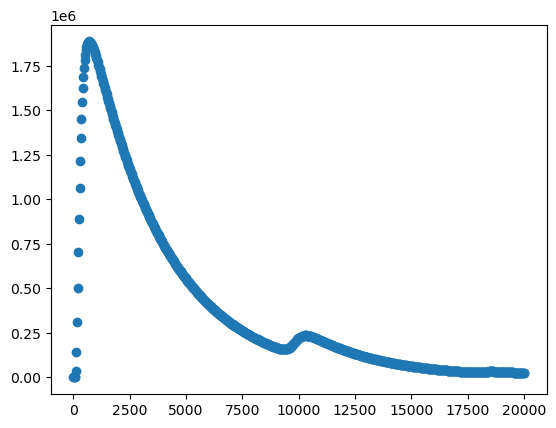

In [ ]:
plt.scatter(full_t, true_full_solution[4])

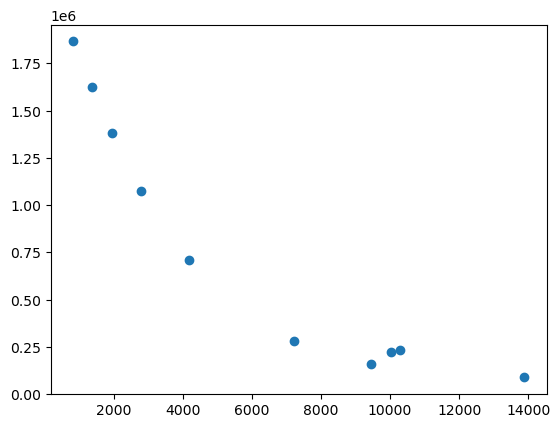

In [ ]:
index_values = index_values2
plt.scatter(full_t[index_values], true_full_solution[4][index_values])

In [ ]:
optimized_params

{'beta': 6.462e-08,
 'k': 0.0080117498766643,
 'd': 0.0036655000654584225,
 'p': 0.09058303568451029,
 'c': 0.09229629699763017,
 'cp': 3.836257369580914e-05,
 'cd': 0.0003390405326867785,
 'ck': 2.245266306966188e-06,
 'r': 0.00011855506107480936}

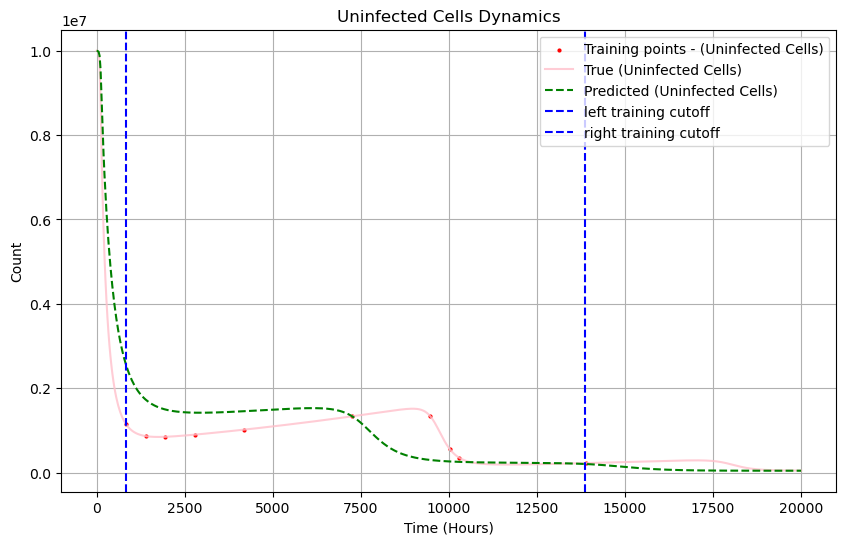

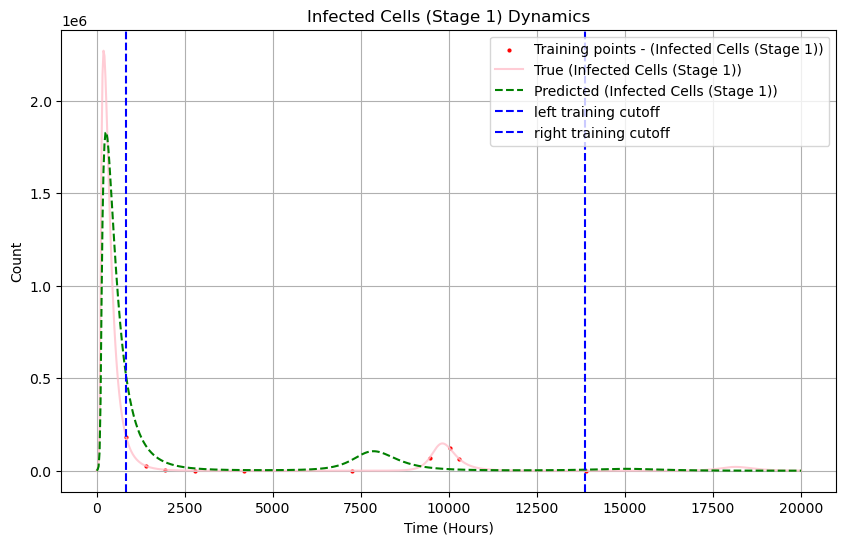

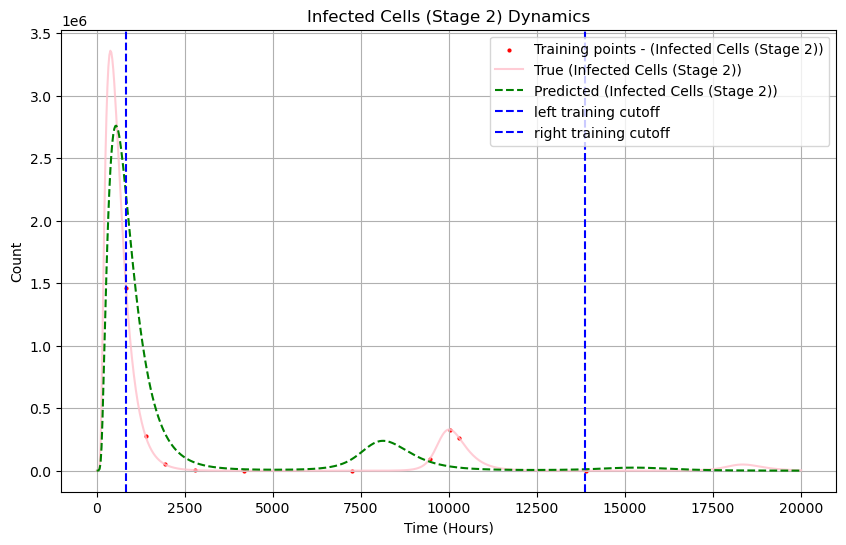

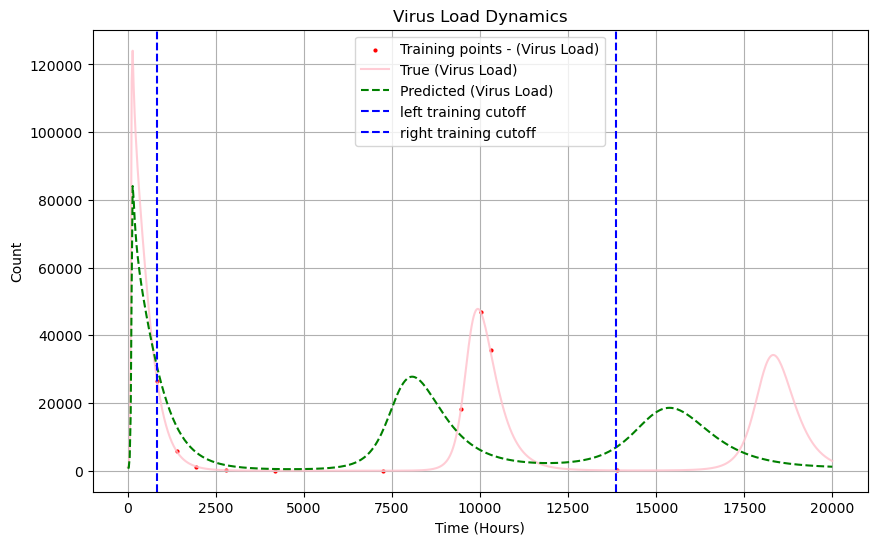

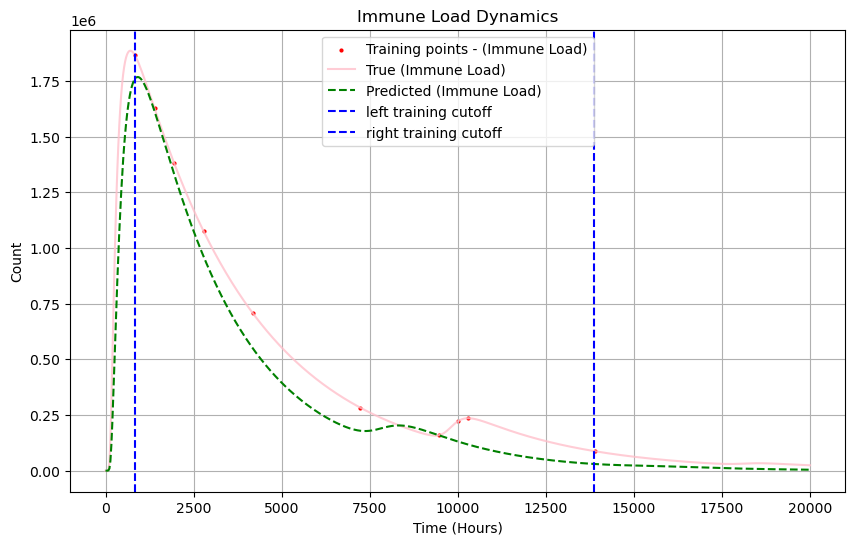

In [ ]:
# Plot results
variables = ["Uninfected Cells", "Infected Cells (Stage 1)", "Infected Cells (Stage 2)", "Virus Load", "Immune Load"]
for i, var in enumerate(variables):
    plt.figure(figsize=(10, 6))
    plt.scatter(t[index_values], true_full_solution[i, index_values], label=f"Training points - ({var})", linestyle="solid", s=4, color='red')
    plt.plot(full_t, true_full_solution[i], label=f"True ({var})", linestyle="solid", color='pink', alpha=0.8)
    plt.plot(full_t, optimized_solution[i], label=f"Predicted ({var})", linestyle="dashed", color='green')
    plt.axvline(x = index_values[0] * (20_000 / 720), color = 'b', label = 'left training cutoff', linestyle="dashed")
    plt.axvline(x = index_values[-1] * (20_000 / 720), color = 'b', label = 'right training cutoff', linestyle="dashed")

    plt.xlabel("Time (Hours)")
    plt.ylabel("Count")
    plt.title(f"{var} Dynamics")
    plt.legend()
    plt.grid()
    plt.show()

<Axes: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=1.000e+00)'>

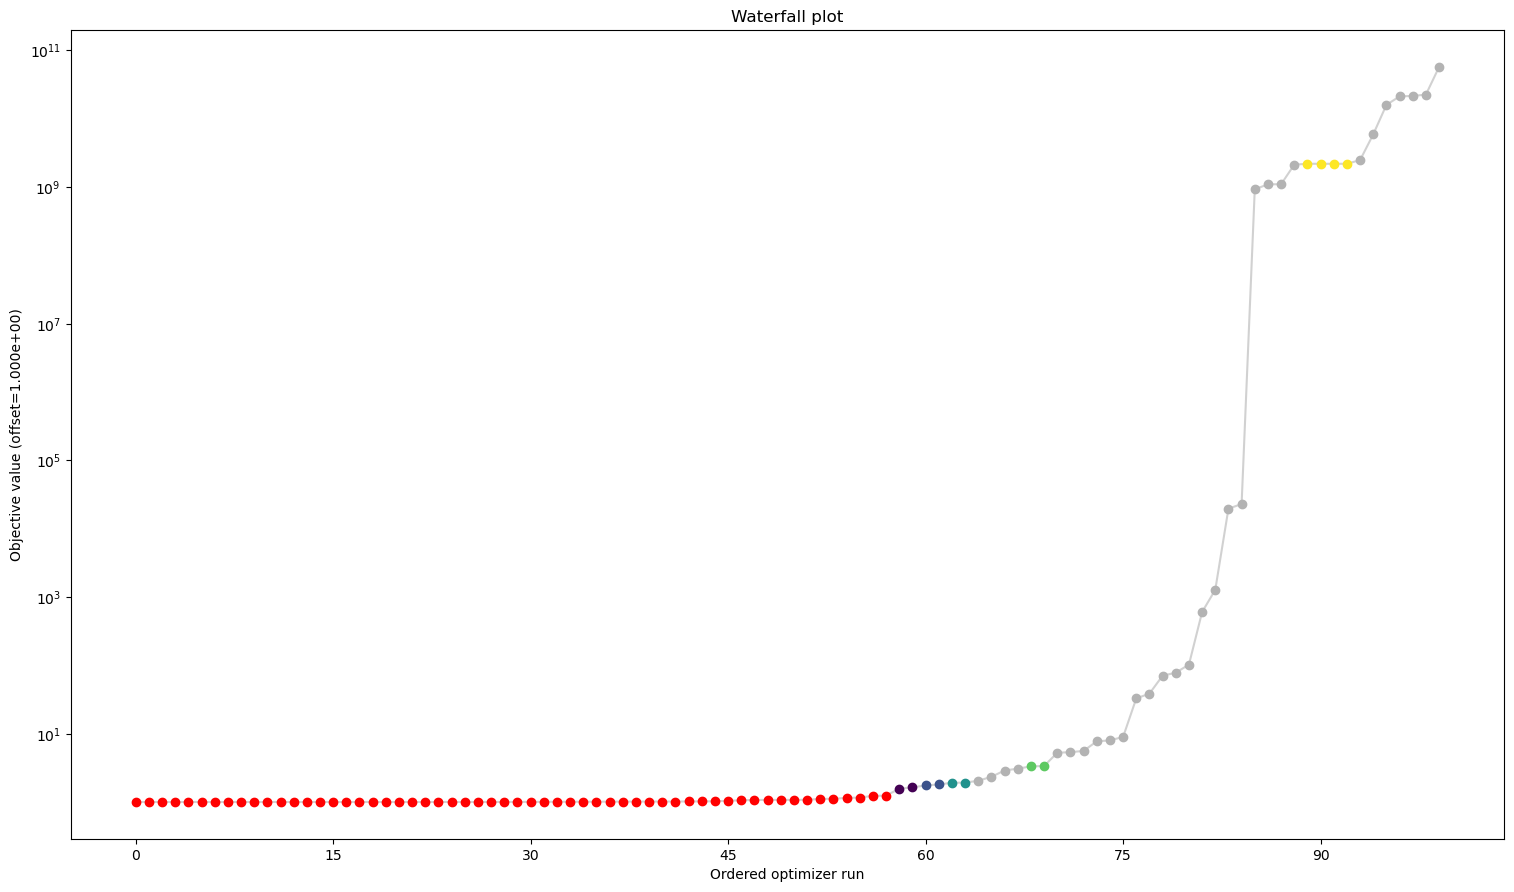

In [ ]:
pypesto.visualize.waterfall(result)


## Model MAEs - Porównywanie (Zadanie 4)

W tym rozdziale zostaną porównane ze sobą wytrenowane modele w zadaniu trzecim. Kod jest w innym notebooku. Dane ładnie są zebrane w prezentacji. Sprawdzany zostanie błąd RMSE na całym przebiegu danych. Modele są w trzech podrozdziałach różniących się ilością punktów oraz zaburzeniem danych sigma. Podrozdział sigma będzie zawierał modele wyszkolone przy użyciu zaszumienia danych wielkości określonej w tytule podrozdziału z wszystkimi ilościami punktów (mało, średnio, dużo)

### Sigma small

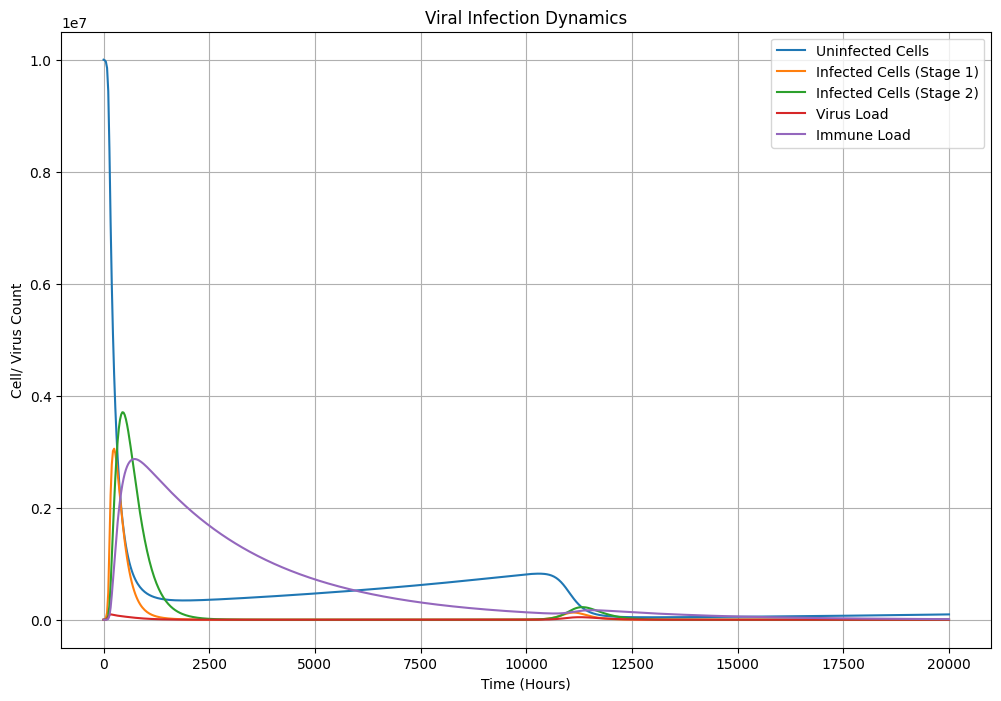

RMSE: 460728.09460919537


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1000 # initial virus load
C0 = 0

# Time points (days)
t = np.linspace(0, 20000, 720)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, V0, C0]

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

def generate_result(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
  U, I1, I2, V, C = y  # simulate for 50 days
  return odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))


results1 = generate_result(y0,t,6.462e-08,0.0080117498766643,0.0036655000654584225,0.09058303568451029,0.09229629699763017,0.00011855506107480936,3.836257369580914e-05,0.0003390405326867785,2.245266306966188e-06, U0)
# Plot results

def plot_result(result):
  U, I1, I2, V, C = result.T
  plt.figure(figsize=(12, 8))
  plt.plot(t, U, label='Uninfected Cells')
  plt.plot(t, I1, label='Infected Cells (Stage 1)')
  plt.plot(t, I2, label='Infected Cells (Stage 2)')
  plt.plot(t, V, label='Virus Load')
  plt.plot(t, C, label='Immune Load')
  plt.xlabel('Time (Hours)')
  plt.ylabel('Cell/ Virus Count')
  plt.legend()
  plt.title('Viral Infection Dynamics')
  plt.grid()
  plt.show()

plot_result(results1)

def calculate_dif(res1, res2):
  U1, _, _, _, _ = res1.T
  U2, _, _, _, _ = res2.T

  print(f"RMSE: {np.sqrt(np.mean((U1-U2)**2))}")

calculate_dif(solution, results1)

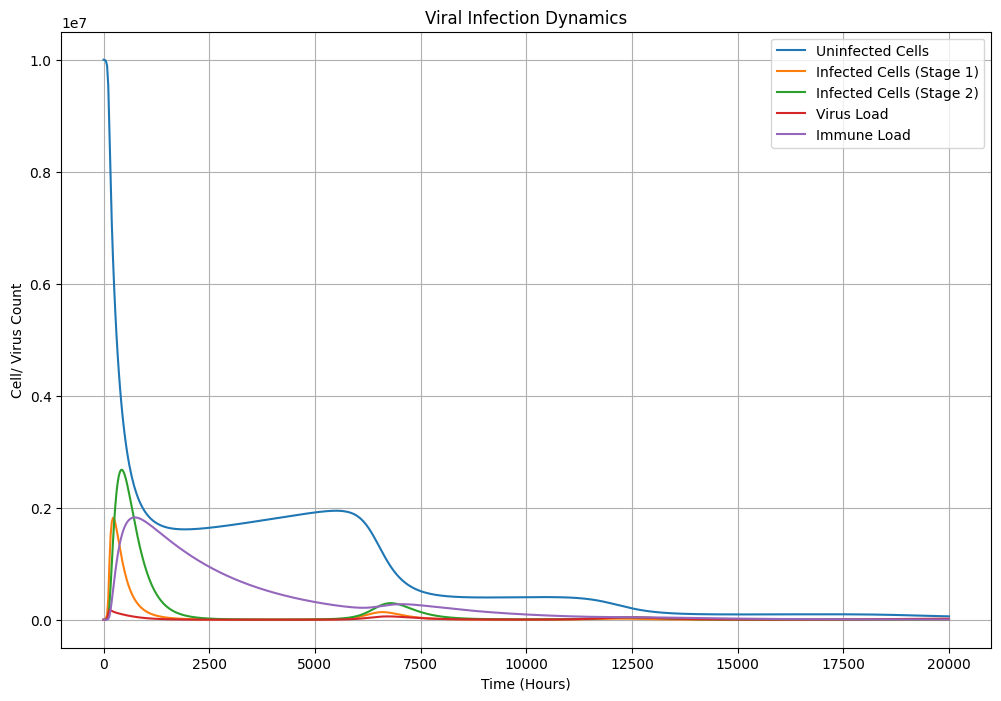

RMSE: 602412.6766165664


In [ ]:
results2 = generate_result(y0,t,2.154e-08,0.01084377061649434,0.00447800880801295,0.20371237173878093,0.05301844084910261,8.98434653583887e-05,4.814110220944816e-05,0.0004400422832274877,3.64749824021482e-06, U0)
plot_result(results2)
calculate_dif(solution, results2)


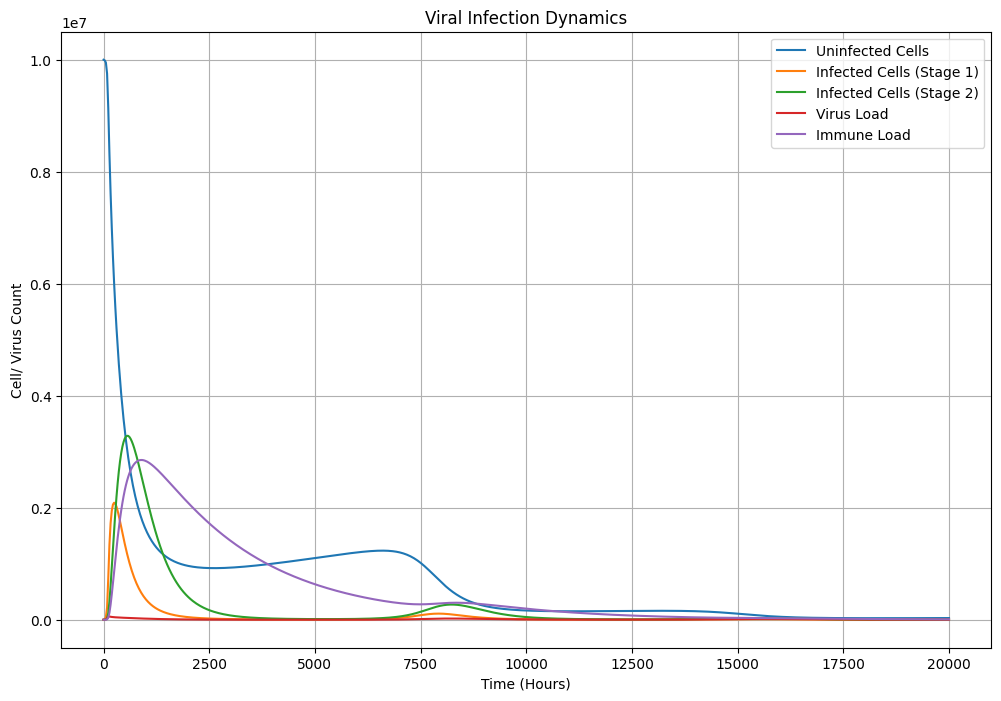

RMSE: 443329.6808469602


In [ ]:
results3 = generate_result(y0,t,5.8785362216307296e-08,0.007523508500248229,0.0026320355084279907,0.11379237849055118,0.06632660938434062,0.00013667317541879323,4.7927265184393525e-05,0.00040423646663344395,4.629640939159198e-06, U0)
plot_result(results3)
calculate_dif(solution, results3)

### Sigmal Medium

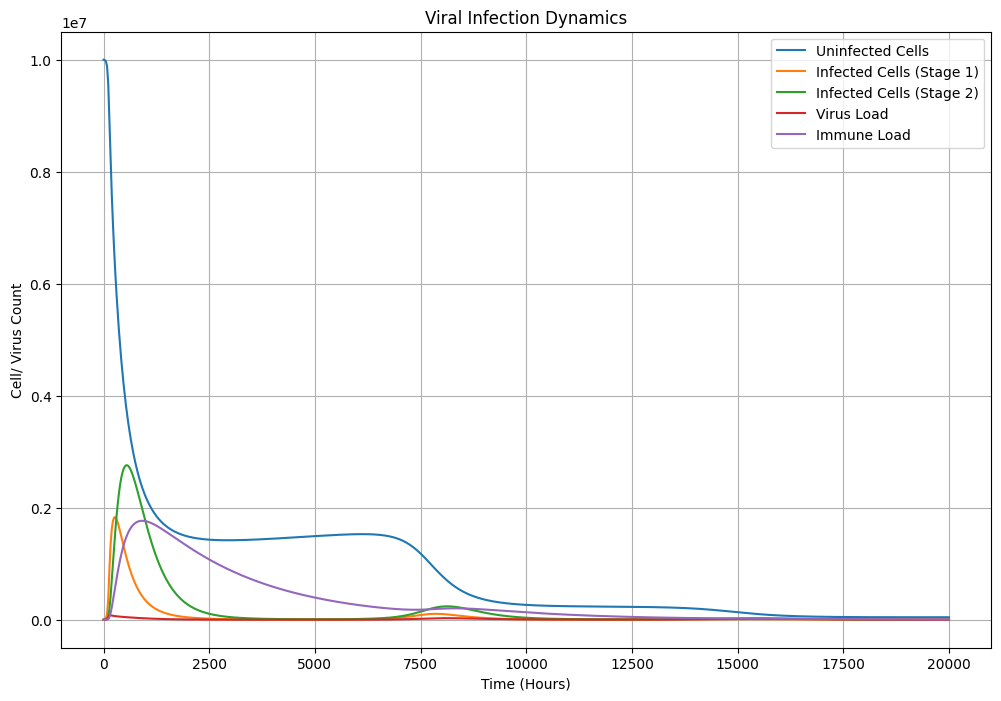

RMSE: 565817.5619179987


In [ ]:
results4 = generate_result(y0,t,3.5535494123623875e-08,0.007982750388969511,0.0031655467861197253,0.13688228435247357,0.05850838263139818,5.679912249923055e-05,3.523557153638079e-05,0.0004048869421043719,5.58997804794434e-06, U0)
plot_result(results4)
calculate_dif(solution, results4)

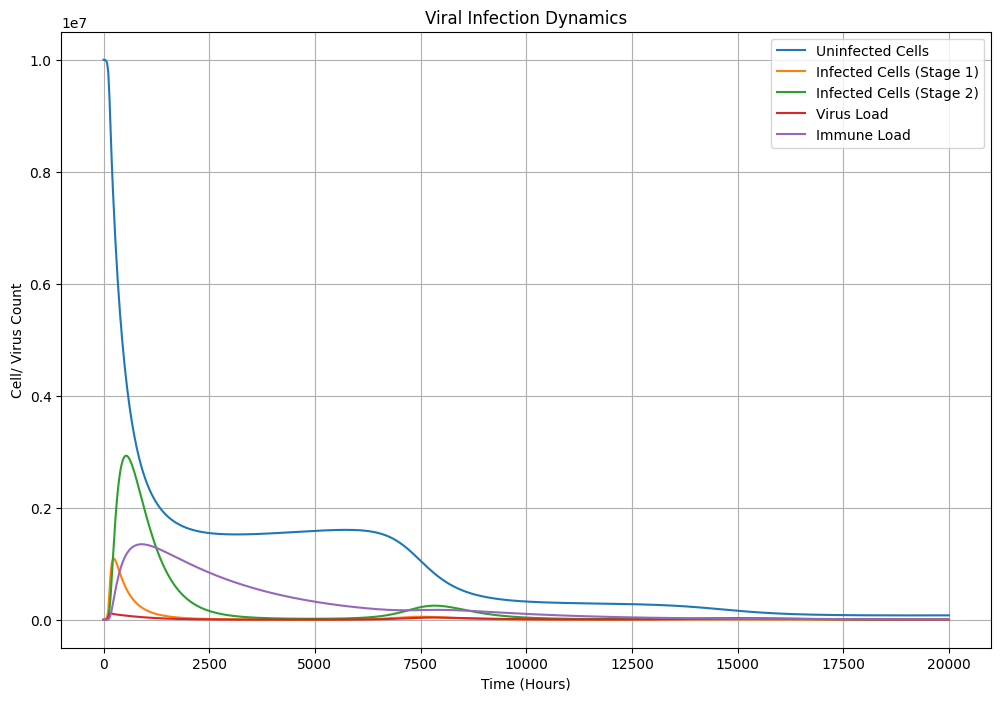

RMSE: 662789.9817197312


In [ ]:
results5 = generate_result(y0,t,2.154e-08,0.01470856645464355,0.002811814962492854,0.17508858467097202,0.09614484705068763,6.857743581049868e-05,6.000000000000001e-05,0.00039170342873431284,6.0e-06, U0)
plot_result(results5)
calculate_dif(solution, results5)

### Sigma big

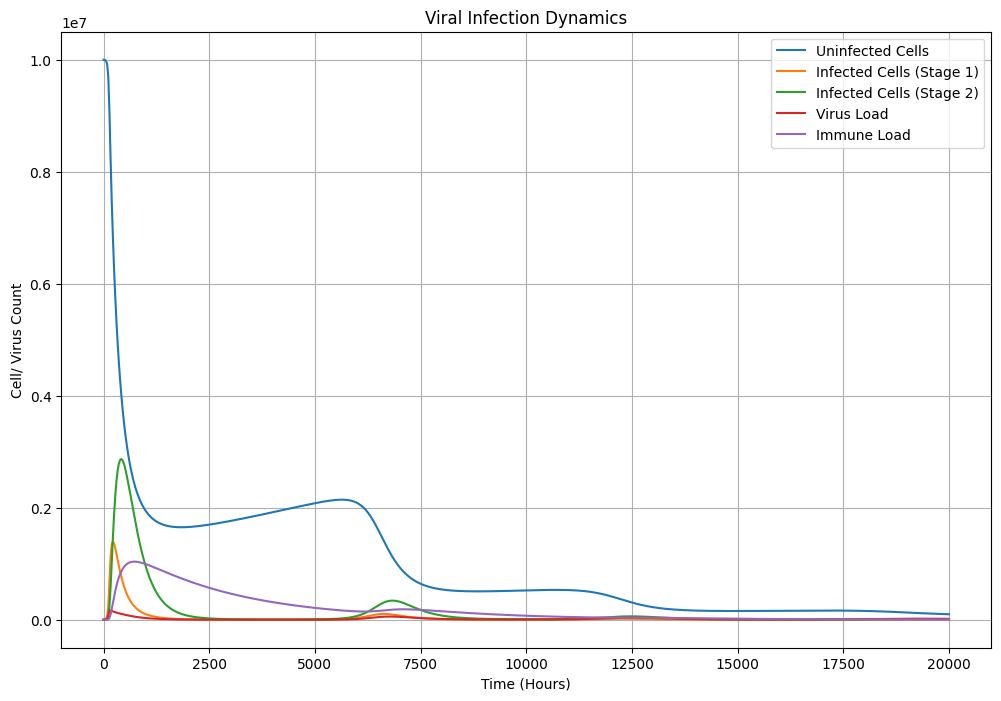

RMSE: 633816.880688436


In [ ]:
results6 = generate_result(y0,t,2.154e-08,0.015671321513850055,0.004236816594035311,0.13021886651669187,0.059127819889072515,0.00011513955735782672,4.237850020095245e-05,0.0003985058672576522,4.097536038398761e-06, U0)
plot_result(results6)
calculate_dif(solution, results6)

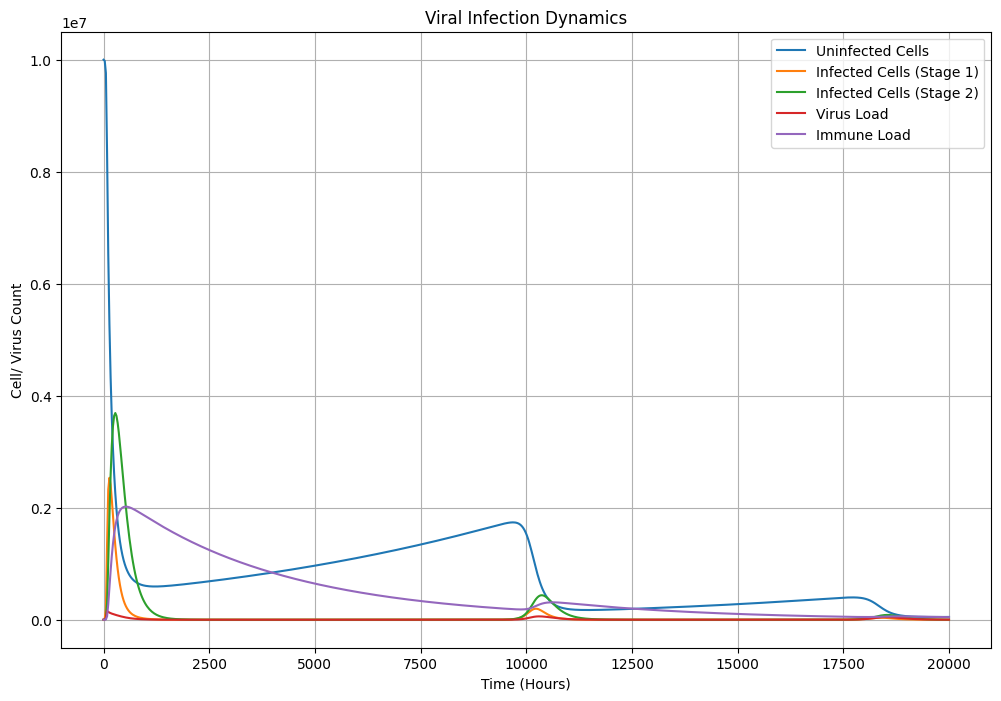

RMSE: 338604.6937180517


In [ ]:
results7 = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,0.005531607325236635,0.18882178337606947,0.0693554120596835,0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,4.687055800442963e-06, U0)
plot_result(results7)
calculate_dif(solution, results7)

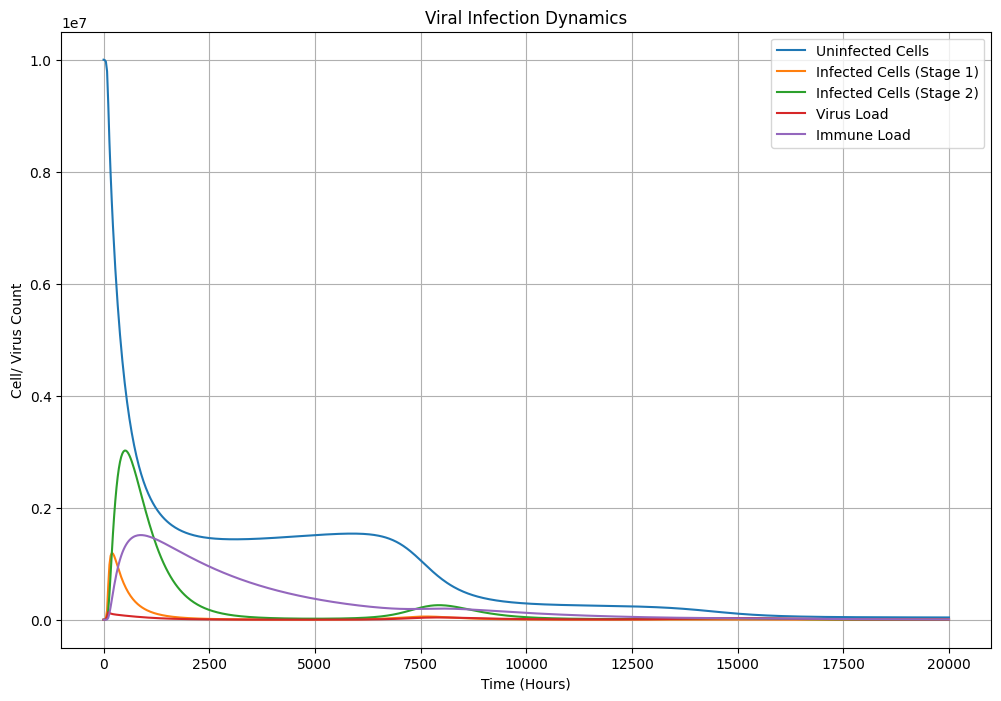

RMSE: 596943.2893526038


In [ ]:
results8 = generate_result(y0,t,2.154e-08,0.01363482481734917,0.0026696072899521145,0.18935514278215035,0.0338476389472138,7.770350444920921e-05,6.000000000000001e-05,0.0003819657007232067,6.0e-06, U0)
plot_result(results8)
calculate_dif(solution, results8)

### Podsumowanie

Najlepszym modelem pod względem RMSE okazał się model z duża sigmą i 10-cioma punktami danych. Ten model zostanie wybrany jako model **MT** dla dalszych zadań. Pozostałe nie odbiegały od niego za dużo. Wszystkie były w zasięgu kilkudziesięciu procent.

## Definicja Surogate Model (Zadanie 5)

Na podstawie analizy czułości przeprowadzonej w zadaniu 2 oraz uwagom Pana Profesora, usunięto z oryginalnego modelu zmienne dynamiczne I1 oraz I2, łącząc je. Wytworzyła się dzięki temu zmienna dynamiczna I i zniknął parametr k. Z uwagi, że parametry r oraz c były najmnmiej czułe, zostały zastąpione przez liczby stałe. Tak oto został stworzony mniejszy model surogatowy, do użycia w następnych zadaniach.

In [ ]:
def viral_infection_surrogate_model(y, t, beta, d, p, cp, cd, ck, U_max):
    U, I, V, C = y
    dU_dt = -beta * U * V + 1e-4 * (1 - (U+I)/U_max) * U
    dI_dt = beta * U * V - d * I
    dV_dt = p * I - 1.09*600*1e-4 * V - ck * C * V
    dC_dt = cp * I**1.3 - cd * C
    return [dU_dt, dI_dt, dV_dt, dC_dt]

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_[:,0] - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0]
    return np.sum(residuals**2)

## Trening Surogate Model (Zadanie 6)

W tym zadaniu zostanie przeprowadzona asymilacja danych na mniejszym modelu surogatowym. Model ten zostanie nauczony, tak aby jak najlepiej odzwierciedlać zachowanie modelu większego. Zostanie on trenowany na przedziale 200 do 500 kroków, samplując co 10-ty krok. Uczony będzie tylko na zmiennej dynamicznej U. Poniżej pokazana jest tylko udana próba. Prób błędnych było bardzo dużo, więc aby uczynić ten notebook czytelnym usunąłem wszytkie złe próby.

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-34-f433853b3cbf>:17: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 2/200 [00:04<08:36,  2.61s/it]<ipython-input-34-f433853b3cbf>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 

Optimized Parameters:
[1.07700000e-08 2.52025242e-03 1.93411275e-01 1.26535473e-05
 4.38697930e-04 3.37085292e-06]


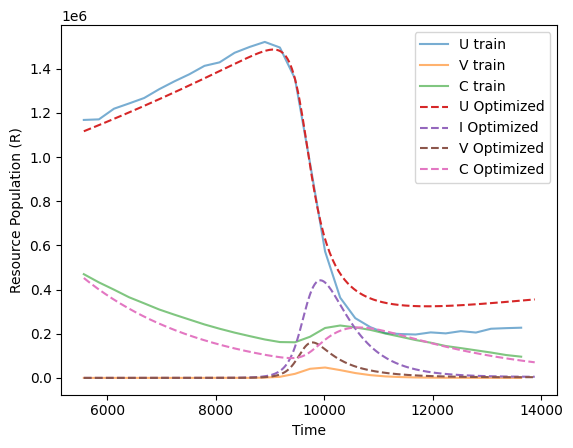

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize

paramss = np.array([beta, d, p, cp, cd, ck])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,[0,3,4]]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100,observed_data_.shape[0])
observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100,observed_data_.shape[0])

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss/4   # Lower bounds
ub = paramss*4 # Upper bounds
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=200)

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params14 = result.optimize_result.list[0]['x']
optimized_solution14 = simulate_model(optimized_params14)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

Jak widać model bardzo dobrze dopasował się do danych uczących. Są lekkie różnice w innych zmiennych, jednakże to jest spowodowane róznicą w budowie owego modelu.

In [ ]:
model_teacher = [1.07700000e-08, 2.52025242e-03, 1.93411275e-01, 1.26535473e-05,
 4.38697930e-04, 3.37085292e-06]

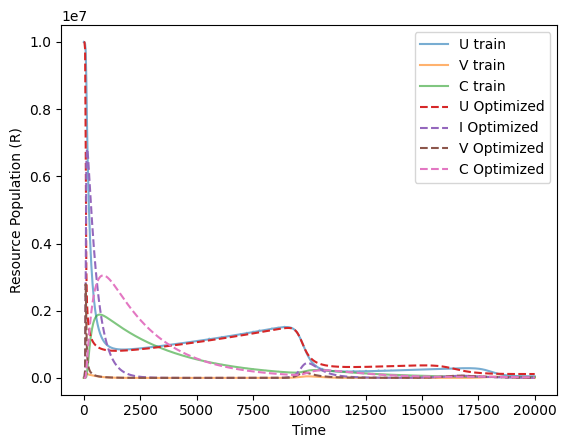

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, optimized_solution14[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,1], label="I Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,2], label="V Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

Na całościowym przebiegu trening wygląda bardzo obiecującą. Znakomicie wpisał się w spadki zmiennej dynamicznej U. Widać miejsca zakażenia oraz reakcję układu odpornościowego.

In [ ]:
model_surogate = [1.07700000e-08, 2.52025242e-03, 1.93411275e-01, 1.26535473e-05,
 4.38697930e-04, 3.37085292e-06]

In [ ]:
solution_sur = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=tuple(model_surogate+[1e7]))

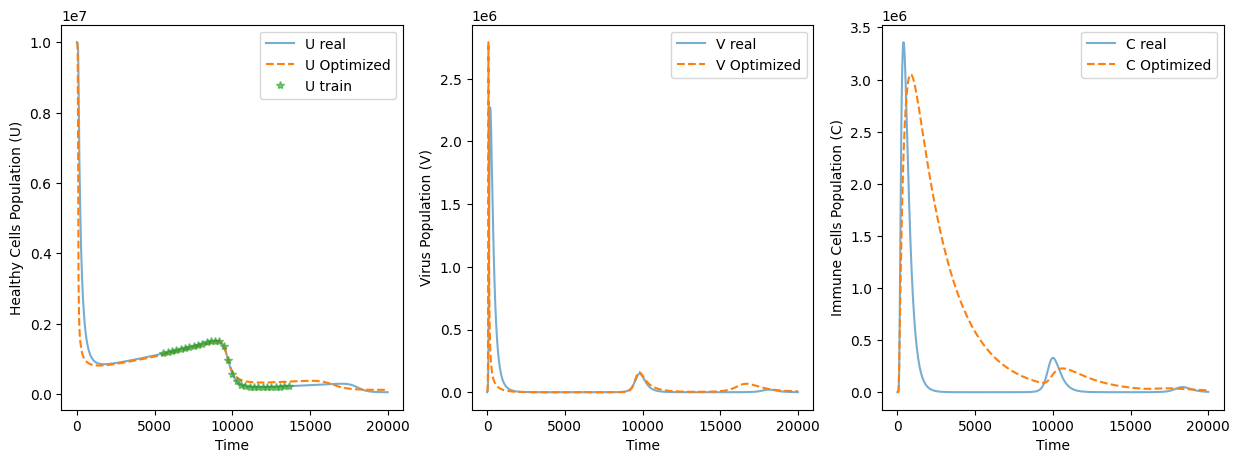

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,5)

axes[0].plot(t, solution[:,0], label="U real", alpha=0.6)
axes[1].plot(t, solution[:,1], label="V real", alpha=0.6)
axes[2].plot(t, solution[:,2], label="C real", alpha=0.6)
axes[0].plot(t, solution_sur[:,0], label="U Optimized", linestyle="--")
axes[1].plot(t, solution_sur[:,2], label="V Optimized", linestyle="--")
axes[2].plot(t, solution_sur[:,3], label="C Optimized", linestyle="--")
axes[0].plot(t[200:500:10], solution[200:500:10,0], '*',label="U train", alpha=0.6)
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[2].set_xlabel("Time")
axes[0].set_ylabel("Healthy Cells Population (U)")
axes[1].set_ylabel("Virus Population (V)")
axes[2].set_ylabel("Immune Cells Population (C)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

Pojedyńcze wykresy lepiej obrazują jak dobrze model dostosował się do danych. Dane U są bardzo dobrze dopasowane (na nich był uczony model). To samo można powiedzieć o wirusach. Układ odpornościowy natomiast widocznie odstaje od wariantu modelu ground truth.

In [ ]:
def calculate_diff(true,pred):
  print(f"RMSE: {np.sqrt(np.mean((true-pred)**2))}")

In [ ]:
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[:,[0,3,4]]

In [ ]:
calculate_diff(observed_data_gen_[:200,0],solution_sur[:200,0])
calculate_diff(observed_data_gen_[:200,1],solution_sur[:200,2])
calculate_diff(observed_data_gen_[:200,2],solution_sur[:200,3])

RMSE: 461918.2003116231
RMSE: 223071.59826805207
RMSE: 574189.8318845055


In [ ]:
calculate_diff(observed_data_gen_[200:500,0],solution_sur[200:500,0])
calculate_diff(observed_data_gen_[200:500,1],solution_sur[200:500,2])
calculate_diff(observed_data_gen_[200:500,2],solution_sur[200:500,3])

RMSE: 249589.52013839709
RMSE: 37313.575489898394
RMSE: 103080.51988411207


In [ ]:
calculate_diff(solution[:200,0],solution_sur[:200,0])
calculate_diff(solution[:200,1],solution_sur[:200,2])
calculate_diff(solution[:200,2],solution_sur[:200,3])

RMSE: 918418.6473815788
RMSE: 433504.55552377336
RMSE: 1443185.225824915


In [ ]:
calculate_diff(solution[200:500,0],solution_sur[200:500,0])
calculate_diff(solution[200:500,3],solution_sur[200:500,2])
calculate_diff(solution[200:500,4],solution_sur[200:500,3])

RMSE: 93279.19711426004
RMSE: 30357.19000962392
RMSE: 45786.04539997711


In [ ]:
calculate_diff(solution[500:,0],solution_sur[500:,0])
calculate_diff(solution[500:,3],solution_sur[500:,2])
calculate_diff(solution[500:,4],solution_sur[500:,3])

RMSE: 90004.5199223802
RMSE: 30224.011232352663
RMSE: 11552.213001000113


In [ ]:
calculate_diff(observed_data_gen_[500:,0],solution_sur[500:,0])
calculate_diff(observed_data_gen_[500:,1],solution_sur[500:,2])
calculate_diff(observed_data_gen_[500:,2],solution_sur[500:,3])

RMSE: 129820.13649791546
RMSE: 32634.24248936587
RMSE: 41555.11100361416


Wszystkie te wartości błędów są dość wysokie, ze względu na bardzo duże wartości populacji. Jendakże w przepatrzeniu na zakres wartości jest to w miarę dobry wynik. Jak widać o wiele lepiej radzi sobie na danych z modelu Ground Truth niż na danych z modelu teacher. Może się to jednak zmienić w destylacji wiedzy, gdzie model będzie się uczył na obu modelach.

## Knowledge Destilation (Zadanie 7)

W tym podejściu, zachowujemy taki sam okres uczenia modelu surogatowego, z taką różnicą, że dogenerowywujemy dane z modelu teachaer. Dane są dogenerowywane bardziej w miejscu trendu spatkowego zmiennej U. Pozwoli nam to dać większy nacisk na modelowanie tego spatku. Błedy na tych punktach są liczone sumą błędów kwadratowych i odpowiednio wagowane pomiedzy danymi z modelu teacher oraz ground truth.

In [5]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
from pypesto.optimize import FidesOptimizer
from pypesto.optimize import PyswarmOptimizer
from pypesto.optimize import CmaOptimizer


def viral_infection_surrogate_model(y, t, beta, d, p, cp, cd, ck, U_max):
    U, I, V, C = y
    dU_dt = -beta * U * V + 1e-4 * (1 - (U+I)/U_max) * U
    dI_dt = beta * U * V - d * I
    dV_dt = p * I - 1.09*600*1e-4 * V - ck * C * V
    dC_dt = cp * I**1.3 - cd * C
    return [dU_dt, dI_dt, dV_dt, dC_dt]

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

def objective_function(x,ltb,utb,step,observed_data_,observed_data_gen_):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[ltb:utb:step,0]
    residuals_gen = observed_data_gen_ - simulated[ltb+(utb-ltb)//3+step//2:utb-(utb-ltb)//3+step//2:step,0]
    return np.sum(residuals**2) * 0.8 + np.sum(residuals_gen**2) * 0.2 #Wagi dla najlepszego (330,400 window) 0.9,0.1 #Wagi dla kolejnego 0.7,0.3

In [7]:
import matplotlib.pyplot as plt
from functools import partial

LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

def knowledge_distilation(n_steps,optimizer, ltb,utb,step):
  paramss = np.array([beta, d, p, cp, cd, ck])
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,2,3]]
  observed_data_ = observed_data[ltb:utb:step,0]
  observed_data_ += np.random.normal(np.mean(observed_data_) / 100, np.std(observed_data_) / 100, observed_data_.shape[0])
  observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[ltb+(utb-ltb)//3+step//2:utb-(utb-ltb)//3+step//2:step,0]

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function,ltb=ltb,utb=utb,step=step,observed_data_=observed_data_,observed_data_gen_=observed_data_gen_))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimizer,n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params8 = result.optimize_result.list[0]['x']
  optimized_solution8 = simulate_model(optimized_params8)

  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,2], label="C train", alpha=0.6)
  plt.plot(t[ltb+(utb-ltb)//3+step//2:utb-(utb-ltb)//3+step//2:step],observed_data_gen_,'*',label='U gen sampled')
  plt.plot(t[ltb:utb:step],observed_data_,'*',label='U truth sampled')
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params8 ,optimized_solution8

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-21-339ba56bc610>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  4%|▎         | 7/200 [00:00<00:19,  9.70it/s]<ipython-input-21-339ba56bc610>:14: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-21-339ba56bc610>:19: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 56%|█████▌    | 111/200 [01:50<00:38,  2.30it/s]<ipython-input-21-339ba56bc610>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_mod

Optimized Parameters:
[1.08908055e-08 5.39318674e-03 1.78297607e-01 2.66419666e-05
 4.28114403e-04 1.10977166e-06]


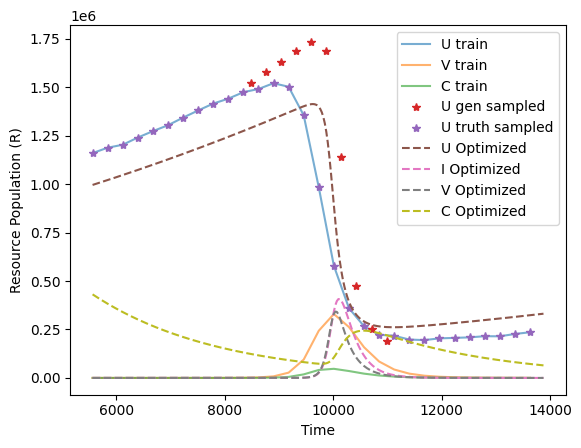

In [ ]:
opt_params5_, opt_solution5_ = knowledge_distilation(200,optimize.ScipyOptimizer(),200,500,10)

Widać, że punkty modelu teacher odbiegają od przebiegu. Powoduje to pewne zaburzenia w treninigu modelu. Jendnakże, dalej bardzo dobrze dopasowywauje się do danych uczących. Co najciekawsze, nowe dane nie ciągna wykresu modelu surogatowego U w strone nowych wydestylowanych danych, lecz w przeciwnym kierunku.

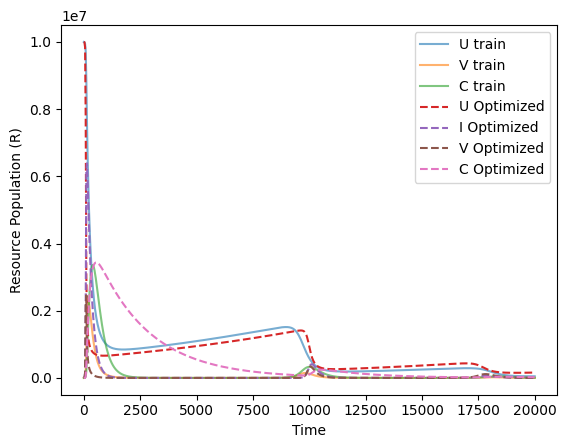

In [ ]:
observed_data = solution[:,:4]
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution5_[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution5_[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution5_[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution5_[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

Tutaj widać, że model bardzo dobrze dopasował się pod względem U na całym przebiegu.

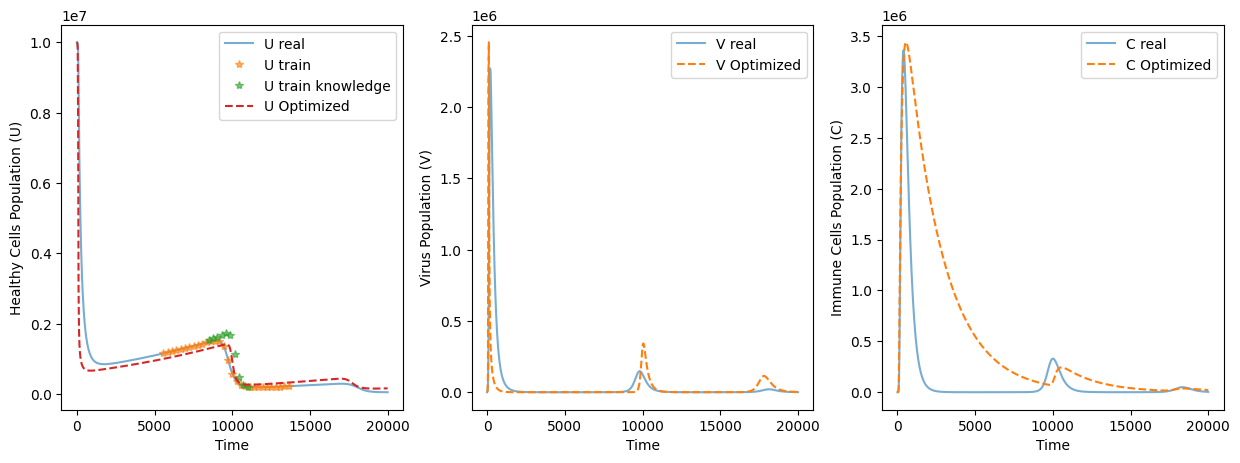

In [11]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,5)
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)

axes[0].plot(t, solution[:,0], label="U real", alpha=0.6)
axes[1].plot(t, solution[:,1], label="V real", alpha=0.6)
axes[2].plot(t, solution[:,2], label="C real", alpha=0.6)
axes[0].plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], solution[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], '*',label="U train", alpha=0.6)
axes[0].plot(t[LOWER_TIME_BOUND+(UPPER_TIME_BOUND-LOWER_TIME_BOUND)//3+STEP//2:UPPER_TIME_BOUND-(UPPER_TIME_BOUND-LOWER_TIME_BOUND)//3+STEP//2:STEP], observed_data_gen_[LOWER_TIME_BOUND+(UPPER_TIME_BOUND-LOWER_TIME_BOUND)//3+STEP//2:UPPER_TIME_BOUND-(UPPER_TIME_BOUND-LOWER_TIME_BOUND)//3+STEP//2:STEP,0], '*',label="U train knowledge", alpha=0.6)
axes[0].plot(t, opt_solution5_[:,0], label="U Optimized", linestyle="--")
axes[1].plot(t, opt_solution5_[:,2], label="V Optimized", linestyle="--")
axes[2].plot(t, opt_solution5_[:,3], label="C Optimized", linestyle="--")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[2].set_xlabel("Time")
axes[0].set_ylabel("Healthy Cells Population (U)")
axes[1].set_ylabel("Virus Population (V)")
axes[2].set_ylabel("Immune Cells Population (C)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

for ax in axes:
    ax.axvline(x=200, color='blue', linestyle='--', label="x = 200")
    ax.axvline(x=500, color='blue', linestyle='--', label="x = 500")

Osobna wizualizacja, pozwalająca się skupić osobno na danych dynamicznych.

In [15]:
calculate_diff(solution[:200,0],opt_solution5_[:200,0])
calculate_diff(solution[:200,3],opt_solution5_[:200:,2])
calculate_diff(solution[:200,4],opt_solution5_[:200:,3])

RMSE: 1013802.6883939995
RMSE: 240514.84659497143
RMSE: 731681.3819642491


In [14]:
calculate_diff(solution[500:,0],opt_solution5_[500:,0])
calculate_diff(solution[500:,3],opt_solution5_[500:,2])
calculate_diff(solution[500:,4],opt_solution5_[500:,3])

RMSE: 110502.02077117644
RMSE: 28821.440192603102
RMSE: 16130.202992438342


In [12]:
calculate_diff(solution[200:500,0],opt_solution5_[200:500,0])
calculate_diff(solution[200:500,3],opt_solution5_[200:500,2])
calculate_diff(solution[200:500,4],opt_solution5_[200:500,3])

RMSE: 163417.5508315274
RMSE: 54160.2988278283
RMSE: 56536.56359273798


In [16]:
calculate_diff(observed_data_gen_[:200,0],opt_solution5_[:200,0])
calculate_diff(observed_data_gen_[:200,3],opt_solution5_[:200:,2])
calculate_diff(observed_data_gen_[:200,4],opt_solution5_[:200:,3])

RMSE: 507544.2982168104
RMSE: 233916.77425354772
RMSE: 635224.1538084758


In [17]:
calculate_diff(observed_data_gen_[500:,0],opt_solution5_[500:,0])
calculate_diff(observed_data_gen_[500:,3],opt_solution5_[500:,2])
calculate_diff(observed_data_gen_[500:,4],opt_solution5_[500:,3])

RMSE: 88702.77793272324
RMSE: 33645.772948488084
RMSE: 46291.23710701698


In [18]:
calculate_diff(observed_data_gen_[200:500,0],opt_solution5_[200:500,0])
calculate_diff(observed_data_gen_[200:500,3],opt_solution5_[200:500,2])
calculate_diff(observed_data_gen_[200:500,4],opt_solution5_[200:500,3])

RMSE: 202111.75470406236
RMSE: 55223.48758863001
RMSE: 111476.97083608792


Błedy są nieco większe niż dla poprzedniego modelu. Powodem jest niestety błąd który wprowadza model teacher. Zaburza działanie modelu, poprzez generację punktów, które są dość mocno oddalone. Nie mniej jednak, różnicy aż tak dużej nie ma, ale nie ma też poprawy.

## Supermodel (Zadanie 8)

Na samym początku, trzeba wybadać jaka zmienna dynamiczna jest najbardziej czuła, aby móc za jej pomocą stworzyć model z mniejszecy modelu krócej trenowanych.

### Analiza czułości

In [ ]:
def viral_infection_surrogate_model(y, t, beta, d, p, cp, cd, ck, U_max):
    U, I, V, C = y
    dU_dt = -beta * U * V + 1e-4 * (1 - (U+I)/U_max) * U
    dI_dt = beta * U * V - d * I
    dV_dt = p * I - 1.09*600*1e-4 * V - ck * C * V
    dC_dt = cp * I**1.3 - cd * C
    return [dU_dt, dI_dt, dV_dt, dC_dt]

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

def objective_function(x,ltb,utb,step,observed_data_):
    simulated = simulate_model(x)[ltb:utb:step]
    residuals = observed_data_ - simulated[:,[0,2,3]]
    return np.sum(residuals**2)

In [ ]:
model_teacher = [1.07700000e-08, 2.52025242e-03, 1.93411275e-01, 1.26535473e-05,
 4.38697930e-04, 3.37085292e-06]

In [ ]:
from SALib.sample import sobol
multiplier = 1.2
problem = {
    'num_vars': 8,
    'names': ['U0','V0','beta', 'd', 'p', 'cp', 'cd', 'ck'],
    'bounds': [
        [U0/multiplier,U0*multiplier],
        [1000/multiplier,1000*multiplier],
        [model_teacher[0]/multiplier, model_teacher[0]*multiplier],
        [model_teacher[1]/multiplier, model_teacher[1]*multiplier],
        [model_teacher[2]/multiplier, model_teacher[2]*multiplier],
        [model_teacher[3]/multiplier, model_teacher[3]*multiplier],
        [model_teacher[4]/multiplier, model_teacher[4]*multiplier],
        [model_teacher[5]/multiplier, model_teacher[5]*multiplier],
    ]
}

In [ ]:
param_values_sobol = sobol.sample(problem, 512, calc_second_order=False)
t = np.linspace(0, 10000, 360)

In [ ]:
def evaluate_model(params):
    U0,V0, beta, d, p, cp, cd, ck = params
    y0 = [U0,0,V0,0]
    solution = odeint(viral_infection_surrogate_model, y0, t, args=(beta, d, p, cp, cd, ck, U0))
    U,I,V,C = solution.T
    return U,I,V,C

In [ ]:
from tqdm import tqdm_notebook

Us, Is, Vs, Cs = [], [], [], []
for params in tqdm_notebook(param_values_sobol):
  U,I,V,C = evaluate_model(params)
  Us.append(U)
  Is.append(I)
  Vs.append(V)
  Cs.append(C)

<ipython-input-182-0859fcdb3ad8>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol):


  0%|          | 0/5120 [00:00<?, ?it/s]

In [ ]:
Us = np.array(Us)
Is = np.array(Is)
Vs = np.array(Vs)
Cs = np.array(Cs)

In [ ]:
from SALib.analyze import sobol

resultsU = []
resultsI = []
resultsV = []
resultsC = []
for time_ in range(1,360):
  resultsU.append(sobol.analyze(problem, Us[:,time_], calc_second_order=False))
  resultsI.append(sobol.analyze(problem, Is[:,time_], calc_second_order=False))
  resultsV.append(sobol.analyze(problem, Vs[:,time_], calc_second_order=False))
  resultsC.append(sobol.analyze(problem, Cs[:,time_], calc_second_order=False))

In [ ]:
S1MatrixU = np.array([result['S1'] for result in resultsU])
STMatrixU = np.array([result['ST'] for result in resultsU])
S1MatrixI = np.array([result['S1'] for result in resultsI])
STMatrixI = np.array([result['ST'] for result in resultsI])
S1MatrixV = np.array([result['S1'] for result in resultsV])
STMatrixV = np.array([result['ST'] for result in resultsV])
S1MatrixC = np.array([result['S1'] for result in resultsC])
STMatrixC = np.array([result['ST'] for result in resultsC])

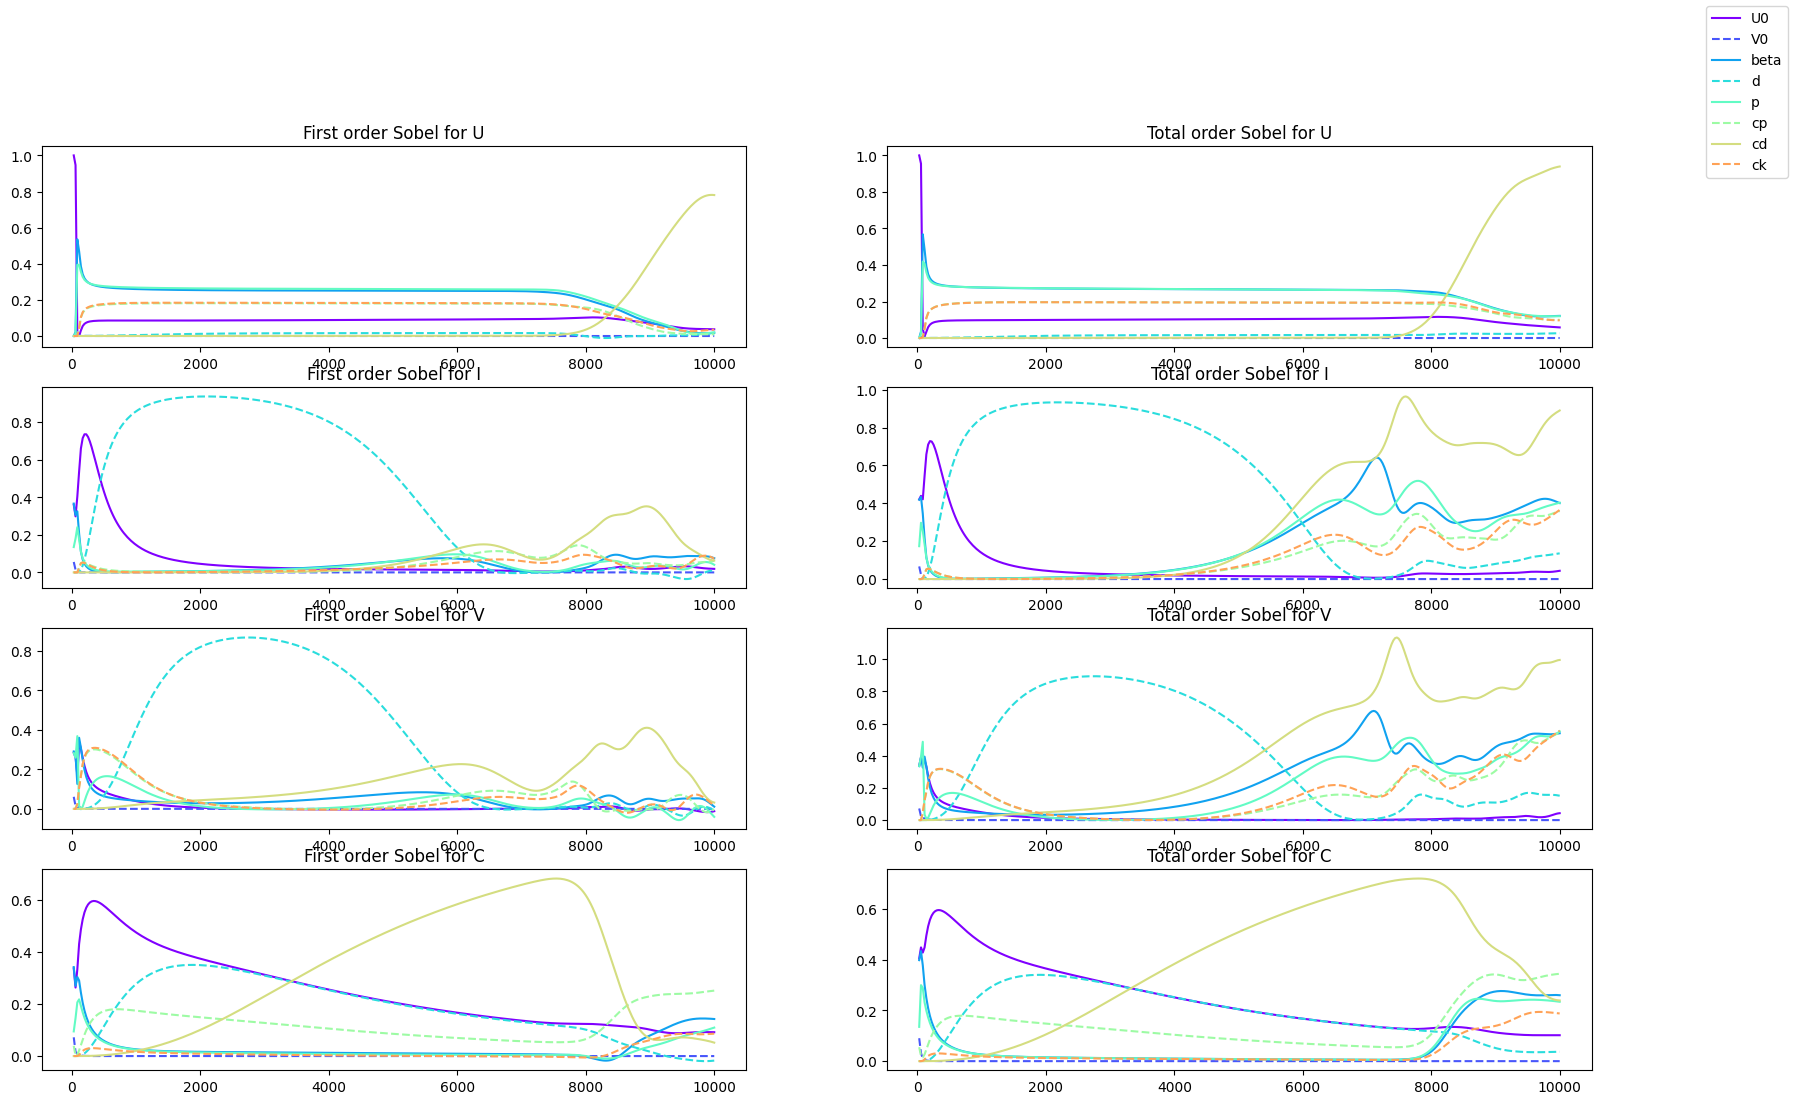

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 10))
fig, axes = plt.subplots(4,2)
matrices = [[S1MatrixU,STMatrixU],
            [S1MatrixI,STMatrixI],
            [S1MatrixV,STMatrixV],
            [S1MatrixC,STMatrixC]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I','V','C']
fig.set_size_inches(20,12)

for row in range(4):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(8),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

Wychodzi na to, że najbardziej czułe są zmienne V oraz I. Jednakże I jest zmienną dynamiczną, której nie ma w modelu ground truth, Temu skupiamy się na V.

### Definicja oraz trening supermodelu

Supermodel składa się z trzech układów tych samych równań, lecz z innym zestawem paraetrów. Zmienna V jest dodatkowo połaczone parametrami c, które pozwalą dostosować się bardziej modelowi.

In [ ]:
class Supermodel:
  def __init__(self,params_set1,params_set2,params_set3):
    self.paramss = [params_set1,params_set2,params_set3]

  def _model(self,index,V_t,V1,V2,U,I,C,c1,c2):
      params = self.paramss[index]
      dU_dt = -params[0] * U * V_t + 1e-4 * (1 - (U+I)/1e7) * U
      dI_dt = params[0] * U * V_t - params[1] * I
      dV_dt = params[2] * I - 1.09*600*1e-4 * V_t - params[5] * C * V_t + c1*(V1-V_t) + c2*(V2-V_t)
      dC_dt = params[3] * I**1.3 - params[4] * C
      return [dU_dt, dI_dt, dV_dt,dC_dt]

  def simulate(self, y, t, c12,c13,c21,c23,c31,c32):
    U1, I1, V1, C1, U2, I2, V2, C2, U3, I3, V3, C3 = y
    outputs = []
    outputs.extend(self._model(0,V1,V2,V3,U1,I1,C1,c12,c13))
    outputs.extend(self._model(1,V2,V1,V3,U2,I2,C2,c21,c23))
    outputs.extend(self._model(2,V3,V1,V2,U3,I3,C3,c31,c32))
    return np.array(outputs)

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
t = np.linspace(0, 20000, 720)

def train_submodel(n_steps, paramss):
  LOWER_TIME_BOUND = 200
  UPPER_TIME_BOUND = 500
  STEP = 10

  # Time points
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,3,4]]
  observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
  observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
  observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100,observed_data_.shape[0])
  observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100,observed_data_.shape[0])

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function,ltb=LOWER_TIME_BOUND,utb=UPPER_TIME_BOUND,step=STEP,observed_data_=observed_data_))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params14 = result.optimize_result.list[0]['x']
  optimized_solution14 = simulate_model(optimized_params14)

  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params14

Trenowanie submodeli będzie się odbywało 4 razy krócej czyli 50 epok.

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 10%|█         | 5/50 [00:00<00:07,  6.27it/s]<ipython-input-203-947943a3bfe0>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 34%|███▍      | 17/50 [00:53<04:17,  7.80s/it]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_mode

Optimized Parameters:
[2.15622145e-08 4.80412026e-03 2.44608815e-01 4.59852313e-05
 4.32349286e-04 2.23321782e-06]


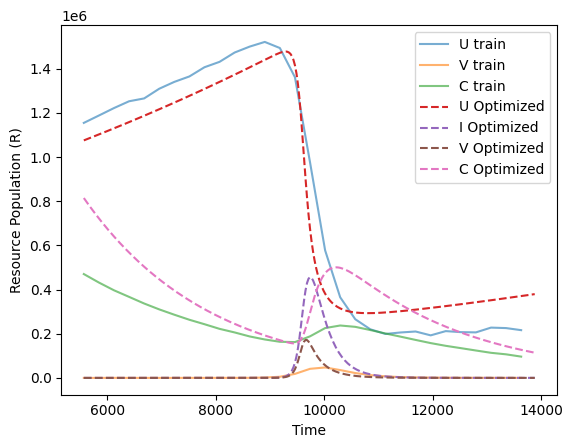

In [ ]:
paramss = np.array([beta, d, p, cp, cd, ck])
model1 = train_submodel(50,paramss)

In [ ]:
paramss

array([4.3080e-08, 4.1700e-03, 1.3644e-01, 4.0000e-05, 3.0000e-04,
       4.0000e-06])

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-203-947943a3bfe0>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  2%|▏         | 1/50 [00:00<00:16,  3.04it/s]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 18%|█▊        | 9/50 [00:05<00:22,  1.79it/s]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model

Optimized Parameters:
[5.50676909e-08 8.52582093e-03 3.54172516e-01 7.45048743e-05
 9.36316802e-04 6.38167612e-06]


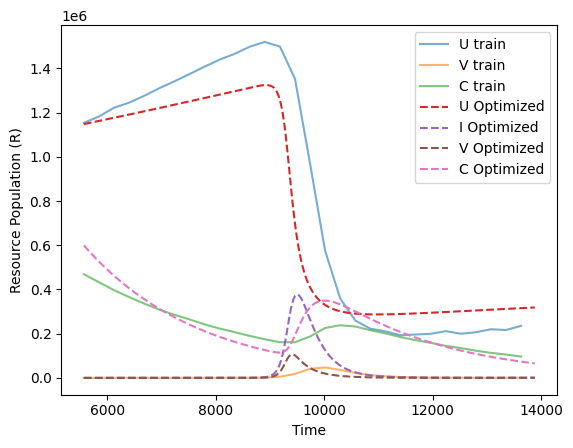

In [ ]:
paramss = np.array([beta - 3e-09, d+3e-04, p, cp*1.05, cd*1.01, ck*.99])
model2 = train_submodel(50,paramss)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-203-947943a3bfe0>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  2%|▏         | 1/50 [00:02<02:07,  2.59s/it]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd,

Optimized Parameters:
[3.39628367e-08 8.96178003e-03 2.40781652e-01 5.18594835e-05
 8.72997685e-04 3.52163417e-06]


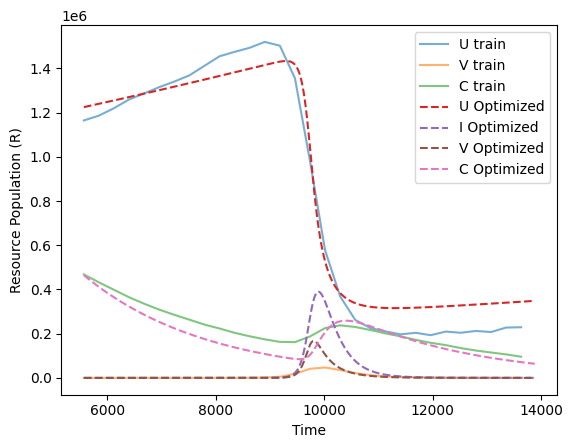

In [ ]:
paramss = np.array([beta * 0.98, d*1.07, p*1.01, cp*0.94, cd*1.01, ck*.99])
model3 = train_submodel(50,paramss)

Wszystkie z tych modeli osiągnęły bardzo ładne wykresy w przedziale uczenia. Czas je załadować do modelu. Wszytkie trzy zestawy parametrów.

In [ ]:
import numpy as np
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
import matplotlib.pyplot as plt

def train_super_model(model_train, y0, paramss, ltb, utb, step, t_steps, paramss_lb = None, paramss_ub = None):
  y0_train = [*y0,*y0,*y0]
  # Time points
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[ltb:utb:step]
  observed_data_ = observed_data[:,[0,3,4]]  # Example: Observing only the resource population R

  # Define the objective function for pyPESTO
  def simulate_model(params):
      c12,c13,c21,c23,c31,c32 = params
      solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
      return solution  # Observing R

  def objective_function(x):
      simulated = simulate_model(x)
      mean_simulated = np.zeros((simulated.shape[0],3))
      mean_simulated[:,0] = simulated[:,[0,4,8]].mean(axis=1)
      mean_simulated[:,1] = simulated[:,[2,6,10]].mean(axis=1)
      mean_simulated[:,2] = simulated[:,[3,7,11]].mean(axis=1)
      residuals = observed_data_ - mean_simulated[ltb:utb:step]
      return np.sum(residuals**2)

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=objective_function)

  # Define the parameter bounds and initial guess
  paramss_lb = paramss - 2* np.abs(paramss) if paramss_lb is None else paramss_lb  # Lower bounds
  paramss_ub = paramss + 2* np.abs(paramss) if paramss_ub is None else paramss_ub# Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=paramss_lb, ub=paramss_ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=t_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params = result.optimize_result.list[0]['x']
  optimized_solution = simulate_model(optimized_params)
  optimized_solution_ = np.zeros((optimized_solution.shape[0],4))
  optimized_solution_[:,0] = optimized_solution[:,[0,4,8]].mean(axis=1)
  optimized_solution_[:,1] = optimized_solution[:,[1,5,9]].mean(axis=1)
  optimized_solution_[:,2] = optimized_solution[:,[2,6,10]].mean(axis=1)
  optimized_solution_[:,3] = optimized_solution[:,[3,7,11]].mean(axis=1)

  plt.plot(t[ltb:utb:step], observed_data_[:,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data_[:,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data_[:,2], label="C train", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params, optimized_solution_

In [ ]:
smodel = Supermodel(model1,model2,model3)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  1%|          | 1/100 [00:00<00:36,  2.69it/s]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  3%|▎         | 3/100 [00:00<00:27,  3.55it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
100%|██████████

Optimized Parameters:
[ 2.64595834 -2.30452675  8.23951449  6.95877253  1.81276893  1.70646095]


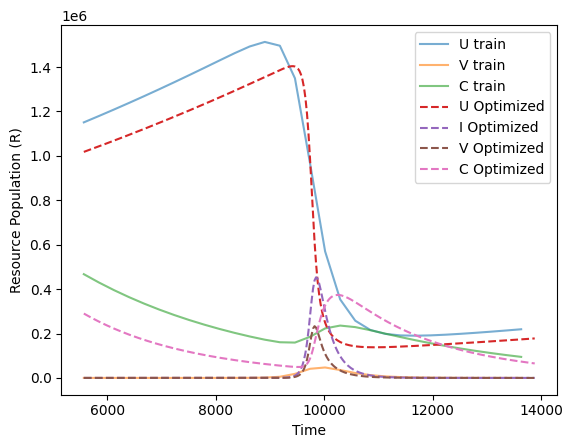

In [ ]:
model_super6, solutions6 = train_super_model(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6)*20 - 10,
 ltb=200,
 utb=500,
 step=10,
 t_steps=100,
 paramss_lb=[-10]*6,
 paramss_ub=[10]*6)

Supermodel trenowany na danych M1 bardzo dobrze doszkolił się do danych. Zmienna U na której bazuje funkcja kosztu jest znakomicie dopasowana.

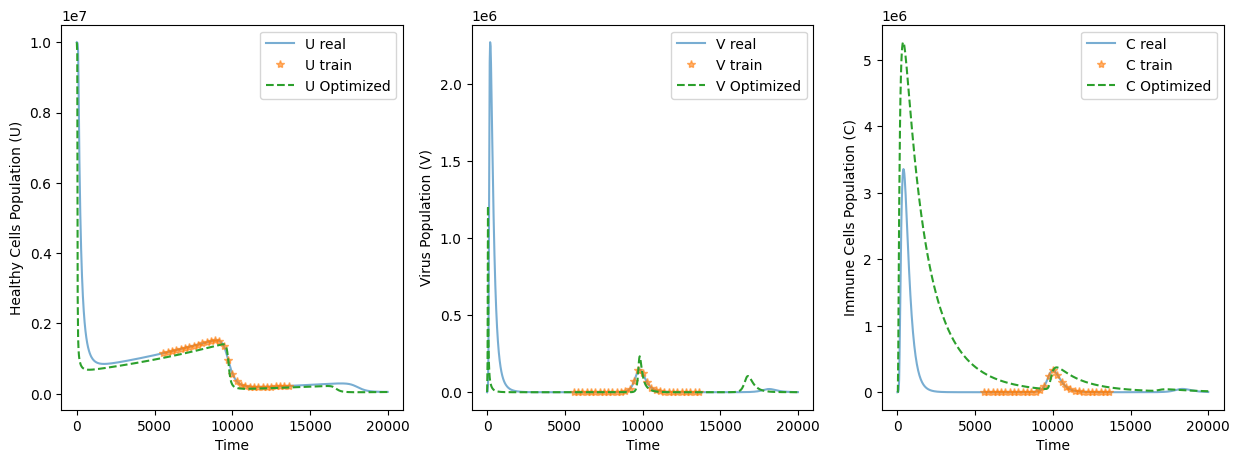

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,5)

axes[0].plot(t, solution[:,0], label="U real", alpha=0.6)
axes[1].plot(t, solution[:,1], label="V real", alpha=0.6)
axes[2].plot(t, solution[:,2], label="C real", alpha=0.6)
axes[0].plot(t[200:500:10], solution[200:500:10,0], '*',label="U train", alpha=0.6)
axes[1].plot(t[200:500:10], solution[200:500:10,1], '*',label="V train", alpha=0.6)
axes[2].plot(t[200:500:10], solution[200:500:10,2], '*',label="C train", alpha=0.6)
axes[0].plot(t, solutions6[:,0], label="U Optimized", linestyle="--")
axes[1].plot(t, solutions6[:,2], label="V Optimized", linestyle="--")
axes[2].plot(t, solutions6[:,3], label="C Optimized", linestyle="--")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[2].set_xlabel("Time")
axes[0].set_ylabel("Healthy Cells Population (U)")
axes[1].set_ylabel("Virus Population (V)")
axes[2].set_ylabel("Immune Cells Population (C)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

**WAŻNE**: Na rysunku każda zmienna ma swoje próbkowanie, lecz w praktyce jedynie zmienne U zostały wykorzystane.

Wykresu bardzo podobne gołym okiem do pozostałych, które wyszkoliliśmy. Dopasowanie U oraz V o wiele lepsze , gdzie C pokazuje róznice w budowie modelu surogatowego.

In [ ]:
calculate_diff(solution[:200,0],solutions6[:200,0])

RMSE: 1350236.8660236557


In [ ]:
calculate_diff(solution[:200,3],solutions6[:200,2])

RMSE: 90905.78380635964


In [ ]:
calculate_diff(solution[:200,4],solutions6[:200,3])

RMSE: 1396995.858141673


In [ ]:
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[:,[0,3,4]]

In [ ]:
calculate_diff(observed_data_gen_[:200,0],solutions6[:200,0])
calculate_diff(observed_data_gen_[:200,1],solutions6[:200,2])
calculate_diff(observed_data_gen_[:200,2],solutions6[:200,3])

RMSE: 933210.7002787276
RMSE: 86421.83872774479
RMSE: 1285650.2809772156


In [ ]:
calculate_diff(observed_data_gen_[200:500,0],solutions6[200:500,0])
calculate_diff(observed_data_gen_[200:500,1],solutions6[200:500,2])
calculate_diff(observed_data_gen_[200:500,2],solutions6[200:500,3])

RMSE: 319646.06596288946
RMSE: 35697.035733850214
RMSE: 158577.3141545915


In [ ]:
calculate_diff(solution[200:500,0],solutions6[200:500,0])
calculate_diff(solution[200:500,3],solutions6[200:500,2])
calculate_diff(solution[200:500,4],solutions6[200:500,3])

RMSE: 132176.13964630393
RMSE: 27662.095300601883
RMSE: 110063.12243916489


In [ ]:
calculate_diff(observed_data_gen_[500:,0],solutions6[500:,0])
calculate_diff(observed_data_gen_[500:,1],solutions6[500:,2])
calculate_diff(observed_data_gen_[500:,2],solutions6[500:,3])

RMSE: 181127.05468860257
RMSE: 32439.57616373835
RMSE: 45642.30791504333


In [ ]:
calculate_diff(solution[500:,0],solutions6[500:,0])
calculate_diff(solution[500:,3],solutions6[500:,2])
calculate_diff(solution[500:,4],solutions6[500:,3])

RMSE: 111952.21584118005
RMSE: 30804.911365800217
RMSE: 16392.925551079315


### Podsumowanie

Ostatecznie supermodel nie był w stanie przebić wyników pozostałych modeli. Jednak w przypadku zmiennej sprzężonej V, wszystkie wyniki wyszły lepiej. Kładzenie większej uwagi na tą zmienną, spowodowało, że model znakomicie dostroił model do niej. Niestey nie poszło to dobrze dla zmiennych U oraz C, które były nie połączone w modelu,